# Validation of 1m runs

Validation of "control" 1 m top runs

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import xarray as xr
import numpy as np
import dask.array
import cosima_cookbook as cc
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma0
# note these gsw numpy functions mean some care is needed to avoid memory issues in very high-res analysis 

import warnings
warnings.filterwarnings('ignore') #ignoring 10% trash warning

## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import cartopy.crs as ccrs
import matplotlib.path as mpath
from matplotlib import rc
import cf_xarray as cf
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

In [2]:
## once you've set up a dask-worker, connect to it, click the dashboard link to check worker status
from dask.distributed import Client
client = Client(n_workers = 48, memory_limit = '1380gb')

## I - Data import

### I.1: MOM5

In [3]:
ice_cutoff=0.15 # curoff in sea ice fraction for calcualtion of ice area and extent
depth_slice = slice(0,1) # depth slice in m for proper comparison with obs

In [4]:
session = cc.database.create_session()

expt_MOM5_1m = '01deg_jra55v13_ryf9091_21mbath' #control
#last year
start_time='1909-01'
end_time='1909-12'
time_slice = slice(start_time,end_time)

lat_north = -59
lat_slice = slice(-90, lat_north)

In [5]:
#importing SST
T_MOM5 = cc.querying.getvar(expt_MOM5_1m, 'temp', session, frequency='1 monthly',chunks={}).sel(yt_ocean=lat_slice) - 273.15
# Separating the age at the bottom 
depth_array_MOM5 = T_MOM5 * 0 + T_MOM5.st_ocean
max_depth_MOM5 = depth_array_MOM5.max(dim = 'st_ocean', skipna= True)
Tob_MOM5 = T_MOM5.where(depth_array_MOM5.st_ocean >= max_depth_MOM5)
Tob_MOM5 = Tob_MOM5.sum(dim = 'st_ocean')
SST_MOM5 = T_MOM5.sel(st_ocean=depth_slice).mean('st_ocean').mean('time')# SST - conservative temperature in K (sheck this is the case for your run)
#importing SSS
S_MOM5= cc.querying.getvar(expt_MOM5_1m, 'salt', session, frequency='1 monthly',chunks={}).sel(yt_ocean=lat_slice) 
Sob_MOM5 = S_MOM5.where(depth_array_MOM5.st_ocean >= max_depth_MOM5)
Sob_MOM5 = Sob_MOM5.sum(dim = 'st_ocean')
SSS_PSU_MOM5 = S_MOM5.sel(st_ocean=depth_slice).mean('st_ocean').mean('time')
#aice_m = ice area  (aggregate), from sea ice model (Ice fraction)
aice_MOM5 = cc.querying.getvar(expt_MOM5_1m, 'aice_m', session, frequency='1 monthly',chunks={})



In [6]:
area_MOM5 = cc.querying.getvar(expt_MOM5_1m, 'area_t', session, n=1).sel(yt_ocean=lat_slice)

In [7]:
#fixing ice file coords to match ocean model ones
aice_MOM5 = aice_MOM5.rename({'ni':'xt_ocean','nj':'yt_ocean'}).isel(yt_ocean = slice(0,510))
aice_MOM5['xt_ocean'] = SST_MOM5.xt_ocean.values
aice_MOM5['yt_ocean'] = SST_MOM5.yt_ocean.values
#masking off conc<0.15
aice_MOM5 = aice_MOM5.where(aice_MOM5>=ice_cutoff)

### I.2: MOM6

In [8]:
start_time_MOM6 ='2000-01'
end_time_MOM6 ='2000-12'
time_slice_MOM6 = slice(start_time,end_time)

expt_MOM6_1m = 'panant-01-zstar-ACCESSyr2' #control

In [9]:
#importing SST
T_MOM6 = cc.querying.getvar(expt_MOM6_1m, 'thetao', session, frequency='1 monthly',chunks={}).sel(yh=lat_slice)
depth_array_MOM6 = T_MOM6 * 0 + T_MOM6.z_l
max_depth_MOM6 = depth_array_MOM6.max(dim = 'z_l', skipna= True)
Tob_MOM6 = T_MOM6.where(depth_array_MOM6.z_l >= max_depth_MOM6)
Tob_MOM6 = Tob_MOM6.sum(dim = 'z_l')
SST_MOM6 = T_MOM6.sel(z_l=depth_slice).mean('z_l').mean('time')# SST - conservative temperature in K (sheck this is the case for your run)
#importing SSS
S_MOM6= cc.querying.getvar(expt_MOM6_1m, 'so', session, frequency='1 monthly',chunks={}).sel(yh=lat_slice) 
Sob_MOM6 = S_MOM6.where(depth_array_MOM6.z_l >= max_depth_MOM6)
Sob_MOM6 = Sob_MOM6.sum(dim = 'z_l')
SSS_PSU_MOM6 = S_MOM6.sel(z_l=depth_slice).mean('z_l').mean('time')
#aice_m = ice area  (aggregate), from sea ice model (Ice fraction)
aice_MOM6 = cc.querying.getvar(expt_MOM6_1m, 'siconc', session, frequency='1 monthly',chunks={})

In [10]:
area_MOM6 = cc.querying.getvar(expt_MOM6_1m, 'areacello', session, n=1).sel(yh=lat_slice) 

In [11]:
#fixing ice file coords to match ocean model ones
aice_MOM6 = aice_MOM6.rename({'xT':'xh','yT':'yh'}).isel(yh = slice(0,510))
aice_MOM6['xh'] = SST_MOM6.xh.values
aice_MOM6['yh'] = SST_MOM6.yh.values
#masking off conc<0.15
aice_MOM6 = aice_MOM6.where(aice_MOM6>=ice_cutoff)

Regridding MOM6 data to match MOM5 for differences

In [12]:
#Regridding SST and Tov
SST_MOM6 = SST_MOM6.interp(xh = SST_MOM5.xt_ocean,yh= SST_MOM5.yt_ocean)
Tob_MOM6 = Tob_MOM6.interp(xh = Tob_MOM5.xt_ocean,yh= Tob_MOM5.yt_ocean)
#Regridding SST
SSS_PSU_MOM6 = SSS_PSU_MOM6.interp(xh = SSS_PSU_MOM5.xt_ocean,yh= SSS_PSU_MOM5.yt_ocean)
Sob_MOM6 = Sob_MOM6.interp(xh = Sob_MOM5.xt_ocean,yh= Sob_MOM5.yt_ocean)

### I.3: Observations

In [13]:
#real world time slice that is used to force the model
forcing_time_slice = slice('1990-05','1991-04')
forcing_time_islice = slice(138,138+12)

In [14]:
#NSIDC v4 ice observations
NSIDC = xr.open_dataset('/g/data/ik11/observations/seaice/NSIDC_v4/seaice_conc_monthly_sh_197811_202312_v04r00.nc')
#area to calculate sea ice extent
NSIDC_area = -(NSIDC.xgrid.diff('x') * NSIDC.ygrid.diff('y'))
# # sea ice fraction
NSIDC_aice = NSIDC.cdr_seaice_conc_monthly.isel(tdim = forcing_time_islice)
NSIDC_aice = NSIDC_aice.where(NSIDC_aice<=1).where(NSIDC_aice>=ice_cutoff) #masking off ice sheet and continent, and conc<0.15
NSIDC_aice = xr.concat((NSIDC_aice.isel(tdim=slice(8,12)),NSIDC_aice.isel(tdim=slice(0,8))),dim='tdim')
NSIDC_aice['tdim']= np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9,  10, 11, 12])


For surface variables we dont have an optimal option. MOM5 uses as IC and salinity restoring target WOA13v2,while MOM6 uses Pauthenet. SO comparying with one or other could be biased, in any case one of them would be comapred against their salinity target. Perhaps it would be useful to compare to both then.

In [15]:
#Importing them
Pauthenet = xr.open_mfdataset('/g/data/ik11/observations/Southern_Ocean_Climatology_PauthenetETAL2021/TS_Climato_Antarctic60S.nc').sel(lat=lat_slice)
WOA = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/*.nc').sel(GRID_Y_T=lat_slice).mean('time')
Schmidtko = xr.open_mfdataset('/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc').sel(lat=lat_slice)

Regridding obs data to match MOM5 for differences

In [16]:
SST_WOA = WOA.temp.sel(ZT = depth_slice).mean('ZT').\
interp(GRID_X_T = SST_MOM5.xt_ocean,GRID_Y_T = SST_MOM5.yt_ocean)
SSS_WOA = WOA.salt.sel(ZT = depth_slice).mean('ZT').\
interp(GRID_X_T = SSS_PSU_MOM5.xt_ocean,GRID_Y_T = SSS_PSU_MOM5.yt_ocean)


In [17]:
Schmidtko_lon =Schmidtko.lon
Schmidtko_lon80 = Schmidtko_lon.where(Schmidtko_lon<=80).fillna(0)
Schmidtko_lon280 = (Schmidtko_lon.where(Schmidtko_lon>80) - 360).fillna(0)
Schmidtko_lon = Schmidtko_lon80 + Schmidtko_lon280
Schmidtko['lon'] = Schmidtko_lon 

In [18]:
Tob_Schmidtko = Schmidtko.CT.interp(lon = SST_MOM5.xt_ocean,lat = SST_MOM5.yt_ocean)
Sob_Schmidtko = Schmidtko.AS.interp(lon = SSS_PSU_MOM5.xt_ocean,lat = SSS_PSU_MOM5.yt_ocean)

### I.4: Calculating sea ice extent

In [36]:
def match_timestamps_to_CDR(ds):
    cice_ds = ds.copy()

    # we are going to use the same timestamps as NSIDC
    cice_ds["time"] = [
        np.datetime64(str(i)[0:7] + "-01T00:00:00.000000000")
        for i in cice_ds.time.values
    ]

    return cice_ds

In [40]:
SIE_MOM5 = (match_timestamps_to_CDR(aice_MOM5).groupby('time.month').mean() * area_MOM5).sum(('xt_ocean','yt_ocean'))
SIE_MOM6 = (match_timestamps_to_CDR(aice_MOM6).groupby('time.month').mean() * area_MOM6).sum(('xh','yh'))
SIE_NSIDC = (NSIDC_aice[:,1:,1:] * NSIDC_area).sum(('x','y'))

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


## II: Anomaly plots

In [41]:
figpath='/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/figs/'

In [21]:
#loading data for faster runs
SST_WOA.load()
SSS_WOA.load()
SST_MOM5.load()
SSS_PSU_MOM5.load()
SST_MOM6.load()
SSS_PSU_MOM6.load()
Sob_MOM6.load()
Sob_MOM5.load()
Tob_MOM6.load()
Tob_MOM5.load()
print('loaded variables')

loaded variables


In [22]:
#For masking WOA data
mask = SSS_PSU_MOM5/SSS_PSU_MOM5

In [23]:
#shelf mask
def shelf_mask_MOM5(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var

In [24]:
#masking off shelf
SST_WOA_shelf = shelf_mask_MOM5(SST_WOA)
SSS_WOA_shelf = shelf_mask_MOM5(SSS_WOA)
SST_MOM5_shelf = shelf_mask_MOM5(SST_MOM5)
SSS_PSU_MOM5_shelf = shelf_mask_MOM5(SSS_PSU_MOM5)
SST_MOM6_shelf = shelf_mask_MOM5(SST_MOM6)
SSS_PSU_MOM6_shelf = shelf_mask_MOM5(SSS_PSU_MOM6)
Sob_MOM6_shelf = shelf_mask_MOM5(Sob_MOM6.mean('time'))
Sob_MOM5_shelf = shelf_mask_MOM5(Sob_MOM5.mean('time'))
Tob_MOM6_shelf = shelf_mask_MOM5(Tob_MOM6.mean('time'))
Tob_MOM5_shelf = shelf_mask_MOM5(Tob_MOM5.mean('time'))
Tob_Schmidtko_shelf = shelf_mask_MOM5(Tob_Schmidtko)
Sob_Schmidtko_shelf = shelf_mask_MOM5(Sob_Schmidtko)

Text(0, 0.5, 'Latitude')

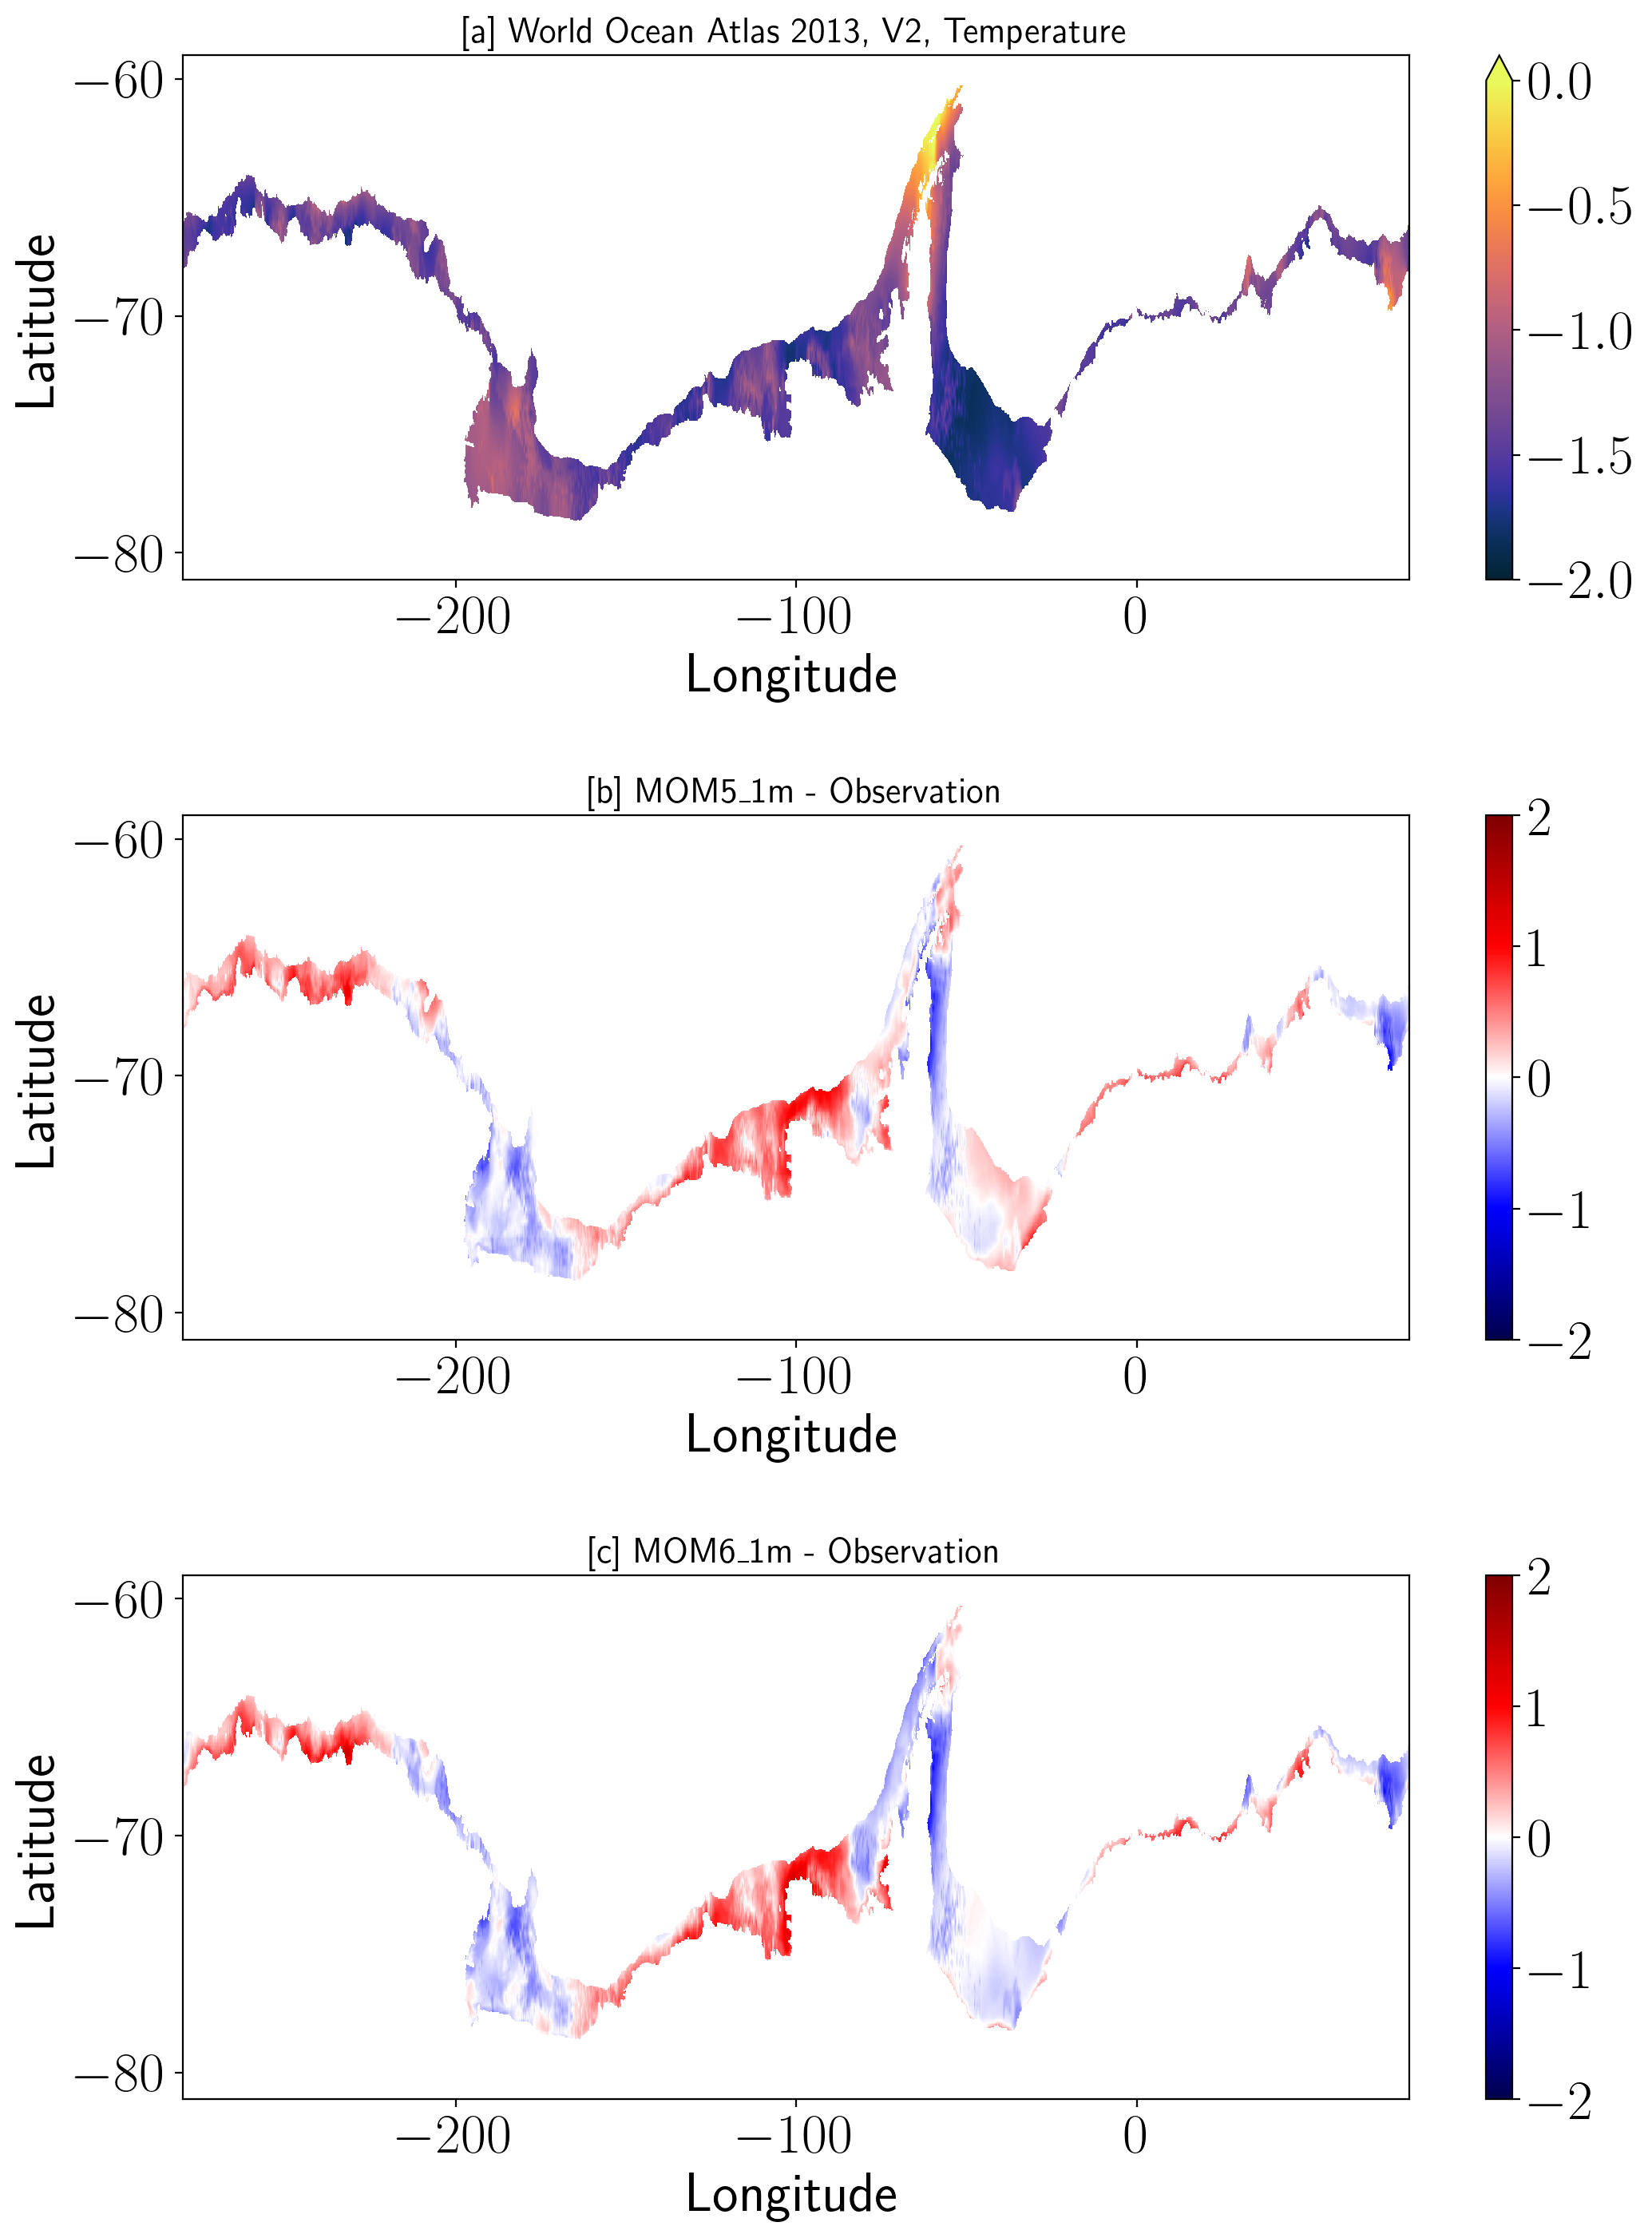

In [25]:
plt.figure (figsize = (12,16))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.35,hspace=0.45)

plt.subplot(3,1,1)
(SST_WOA_shelf * mask).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[a] World Ocean Atlas 2013, V2, Temperature', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,2)
(SST_MOM5_shelf - SST_WOA_shelf).plot(vmin=-2,vmax=2,cmap='seismic')
plt.title('[b] MOM5_1m - Observation', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
(SST_MOM6_shelf - SST_WOA_shelf).plot(vmin=-2,vmax=2,cmap='seismic')
plt.title('[c] MOM6_1m - Observation', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

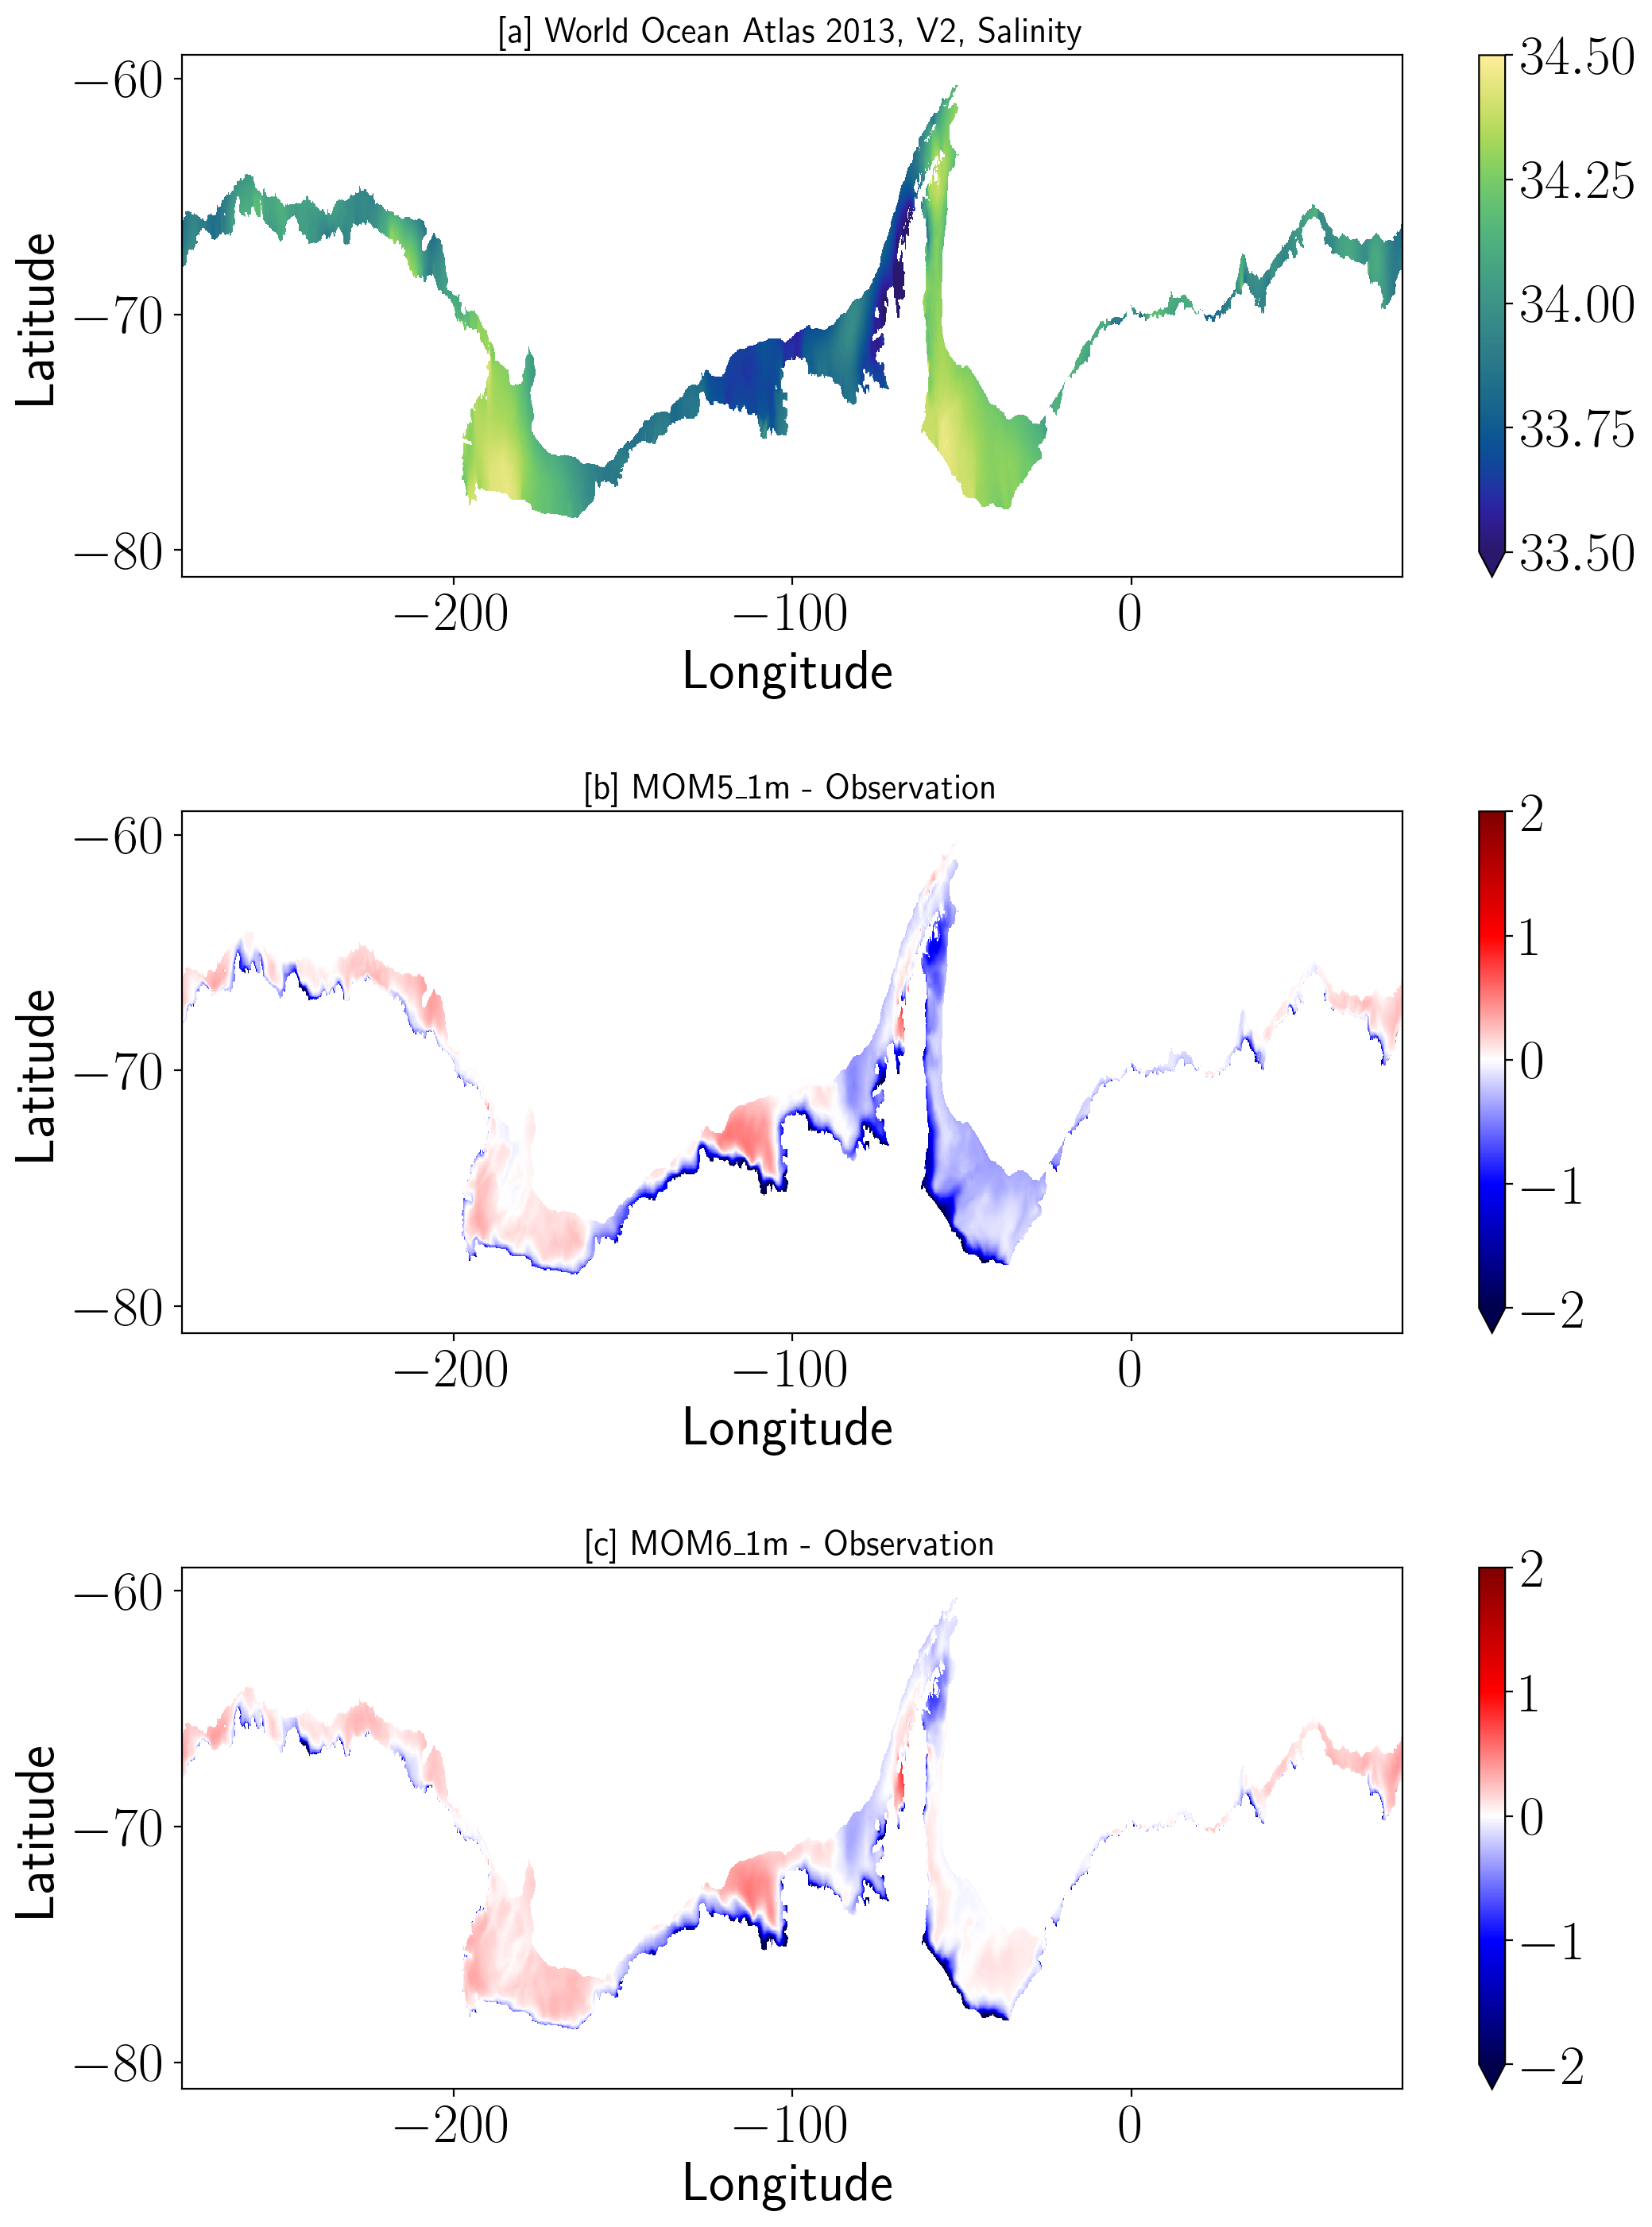

In [26]:
plt.figure (figsize = (12,16))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.35,hspace=0.45)

plt.subplot(3,1,1)
(SSS_WOA_shelf * mask).plot(vmin=33.5,vmax=34.5,cmap=cmo.haline)
plt.title('[a] World Ocean Atlas 2013, V2, Salinity', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,2)
(SSS_PSU_MOM5_shelf - SSS_WOA_shelf).plot(vmin=-2,vmax=2,cmap='seismic')
plt.title('[b] MOM5_1m - Observation', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
(SSS_PSU_MOM6_shelf - SSS_WOA_shelf).plot(vmin=-2,vmax=2,cmap='seismic')
plt.title('[c] MOM6_1m - Observation', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## III: Mean field plots

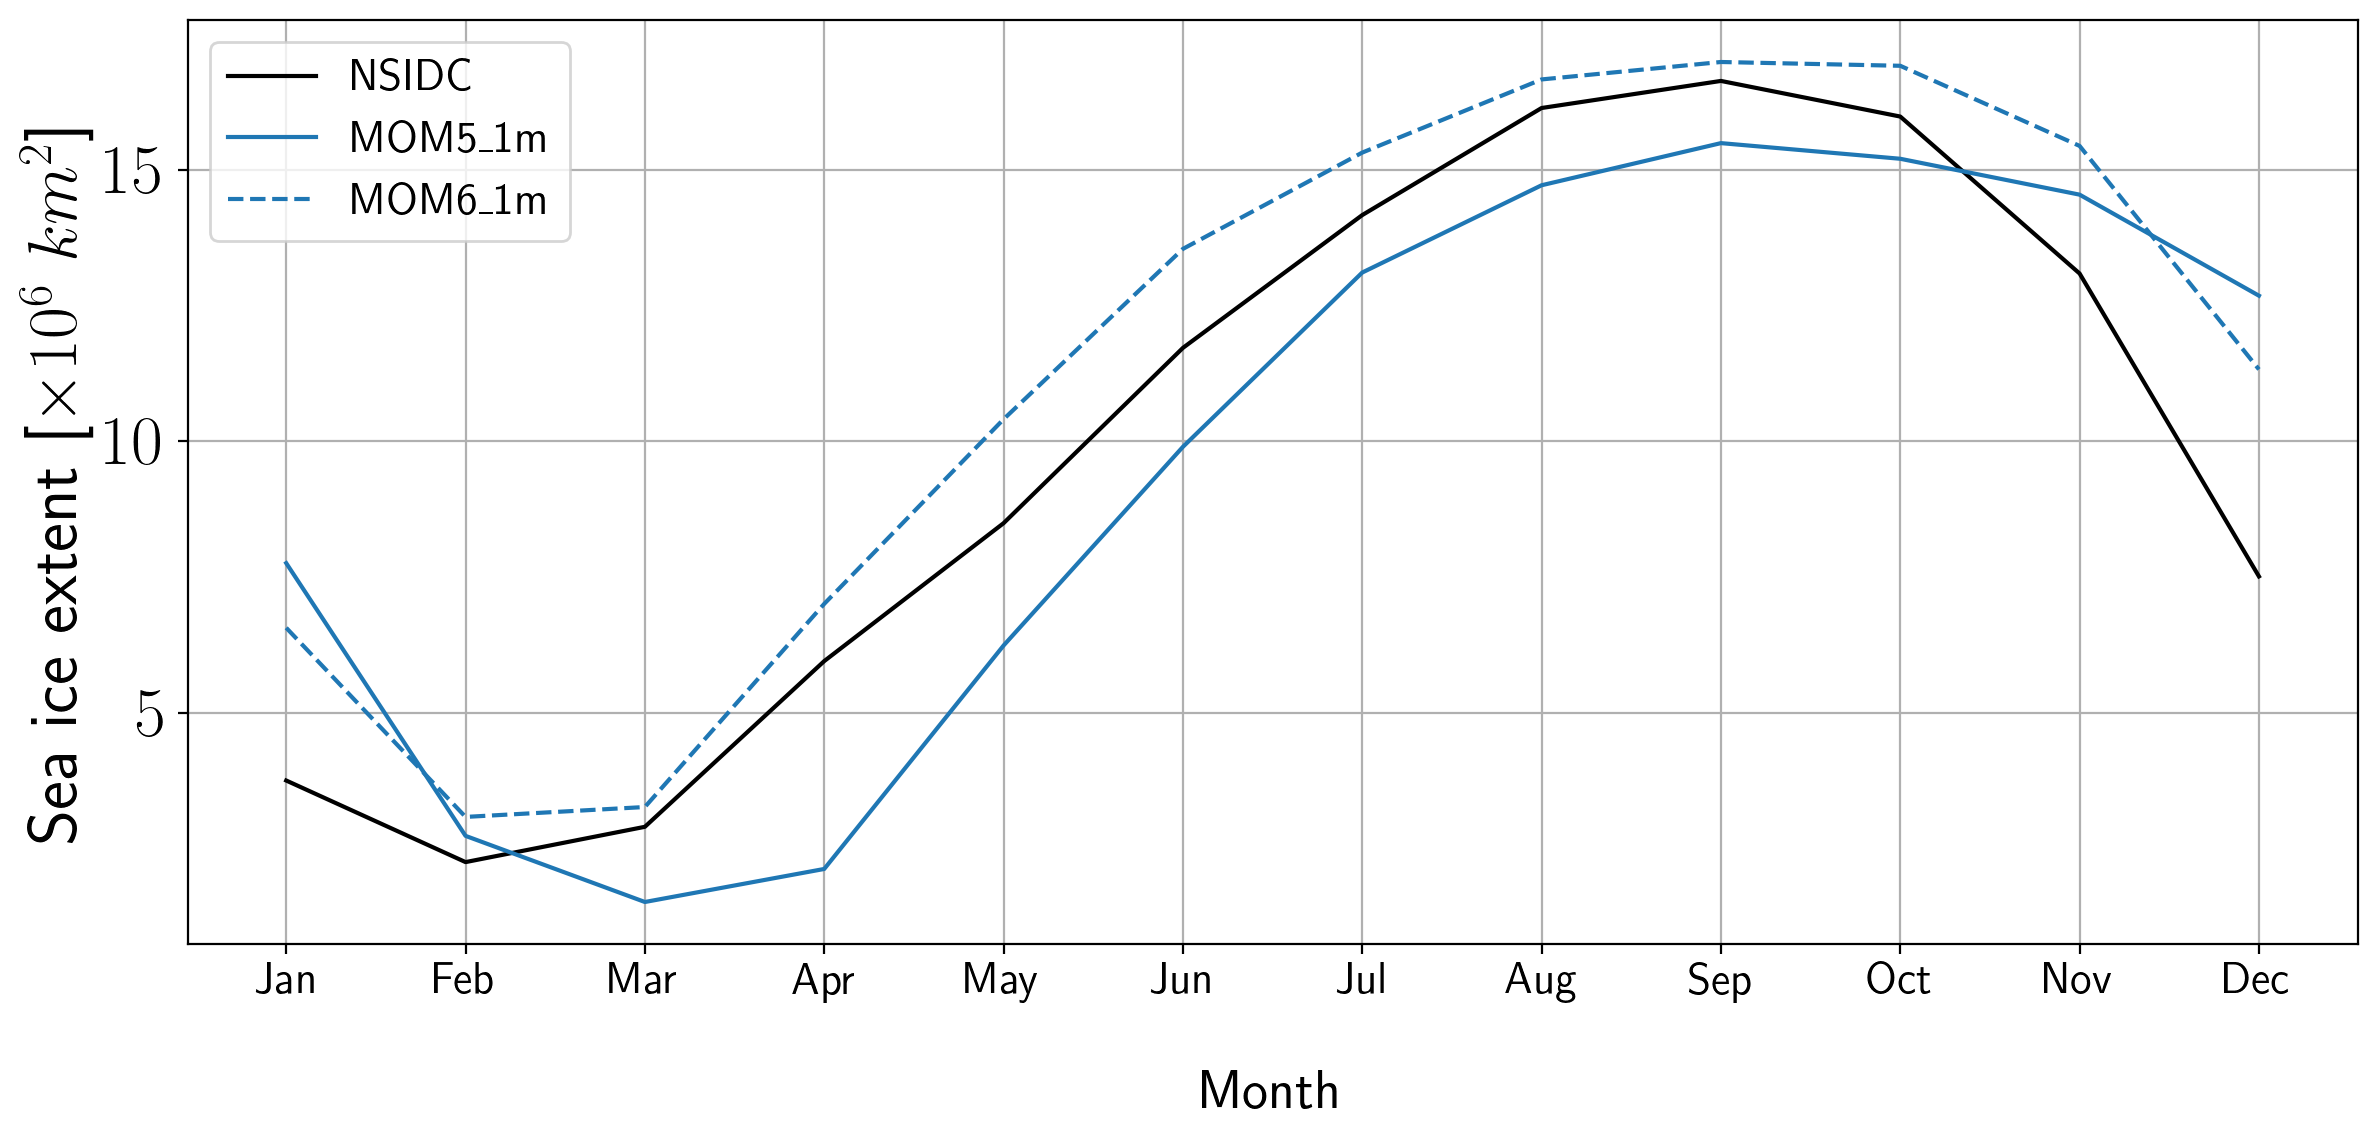

In [43]:
plt.figure(figsize = (14,6))
Month_labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
(1e-12 * SIE_NSIDC).plot(color='k',label='NSIDC')
(1e-12 * SIE_MOM5).plot(color='tab:blue',label='MOM5_1m')
(1e-12 * SIE_MOM6).plot(color='tab:blue',linestyle= '--',label='MOM6_1m')
plt.legend(fontsize=16)
plt.ylabel(r'Sea ice extent [$\times 10^6\ km^2$]')
plt.grid()
plt.xticks(ticks = range(1,13),labels = Month_labels,fontsize=16)
plt.xlabel('\n Month',fontsize = 20)
plt.savefig(figpath+'Rv0_Figure_S9.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'Rv0_Figure_S9.pdf',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Latitude')

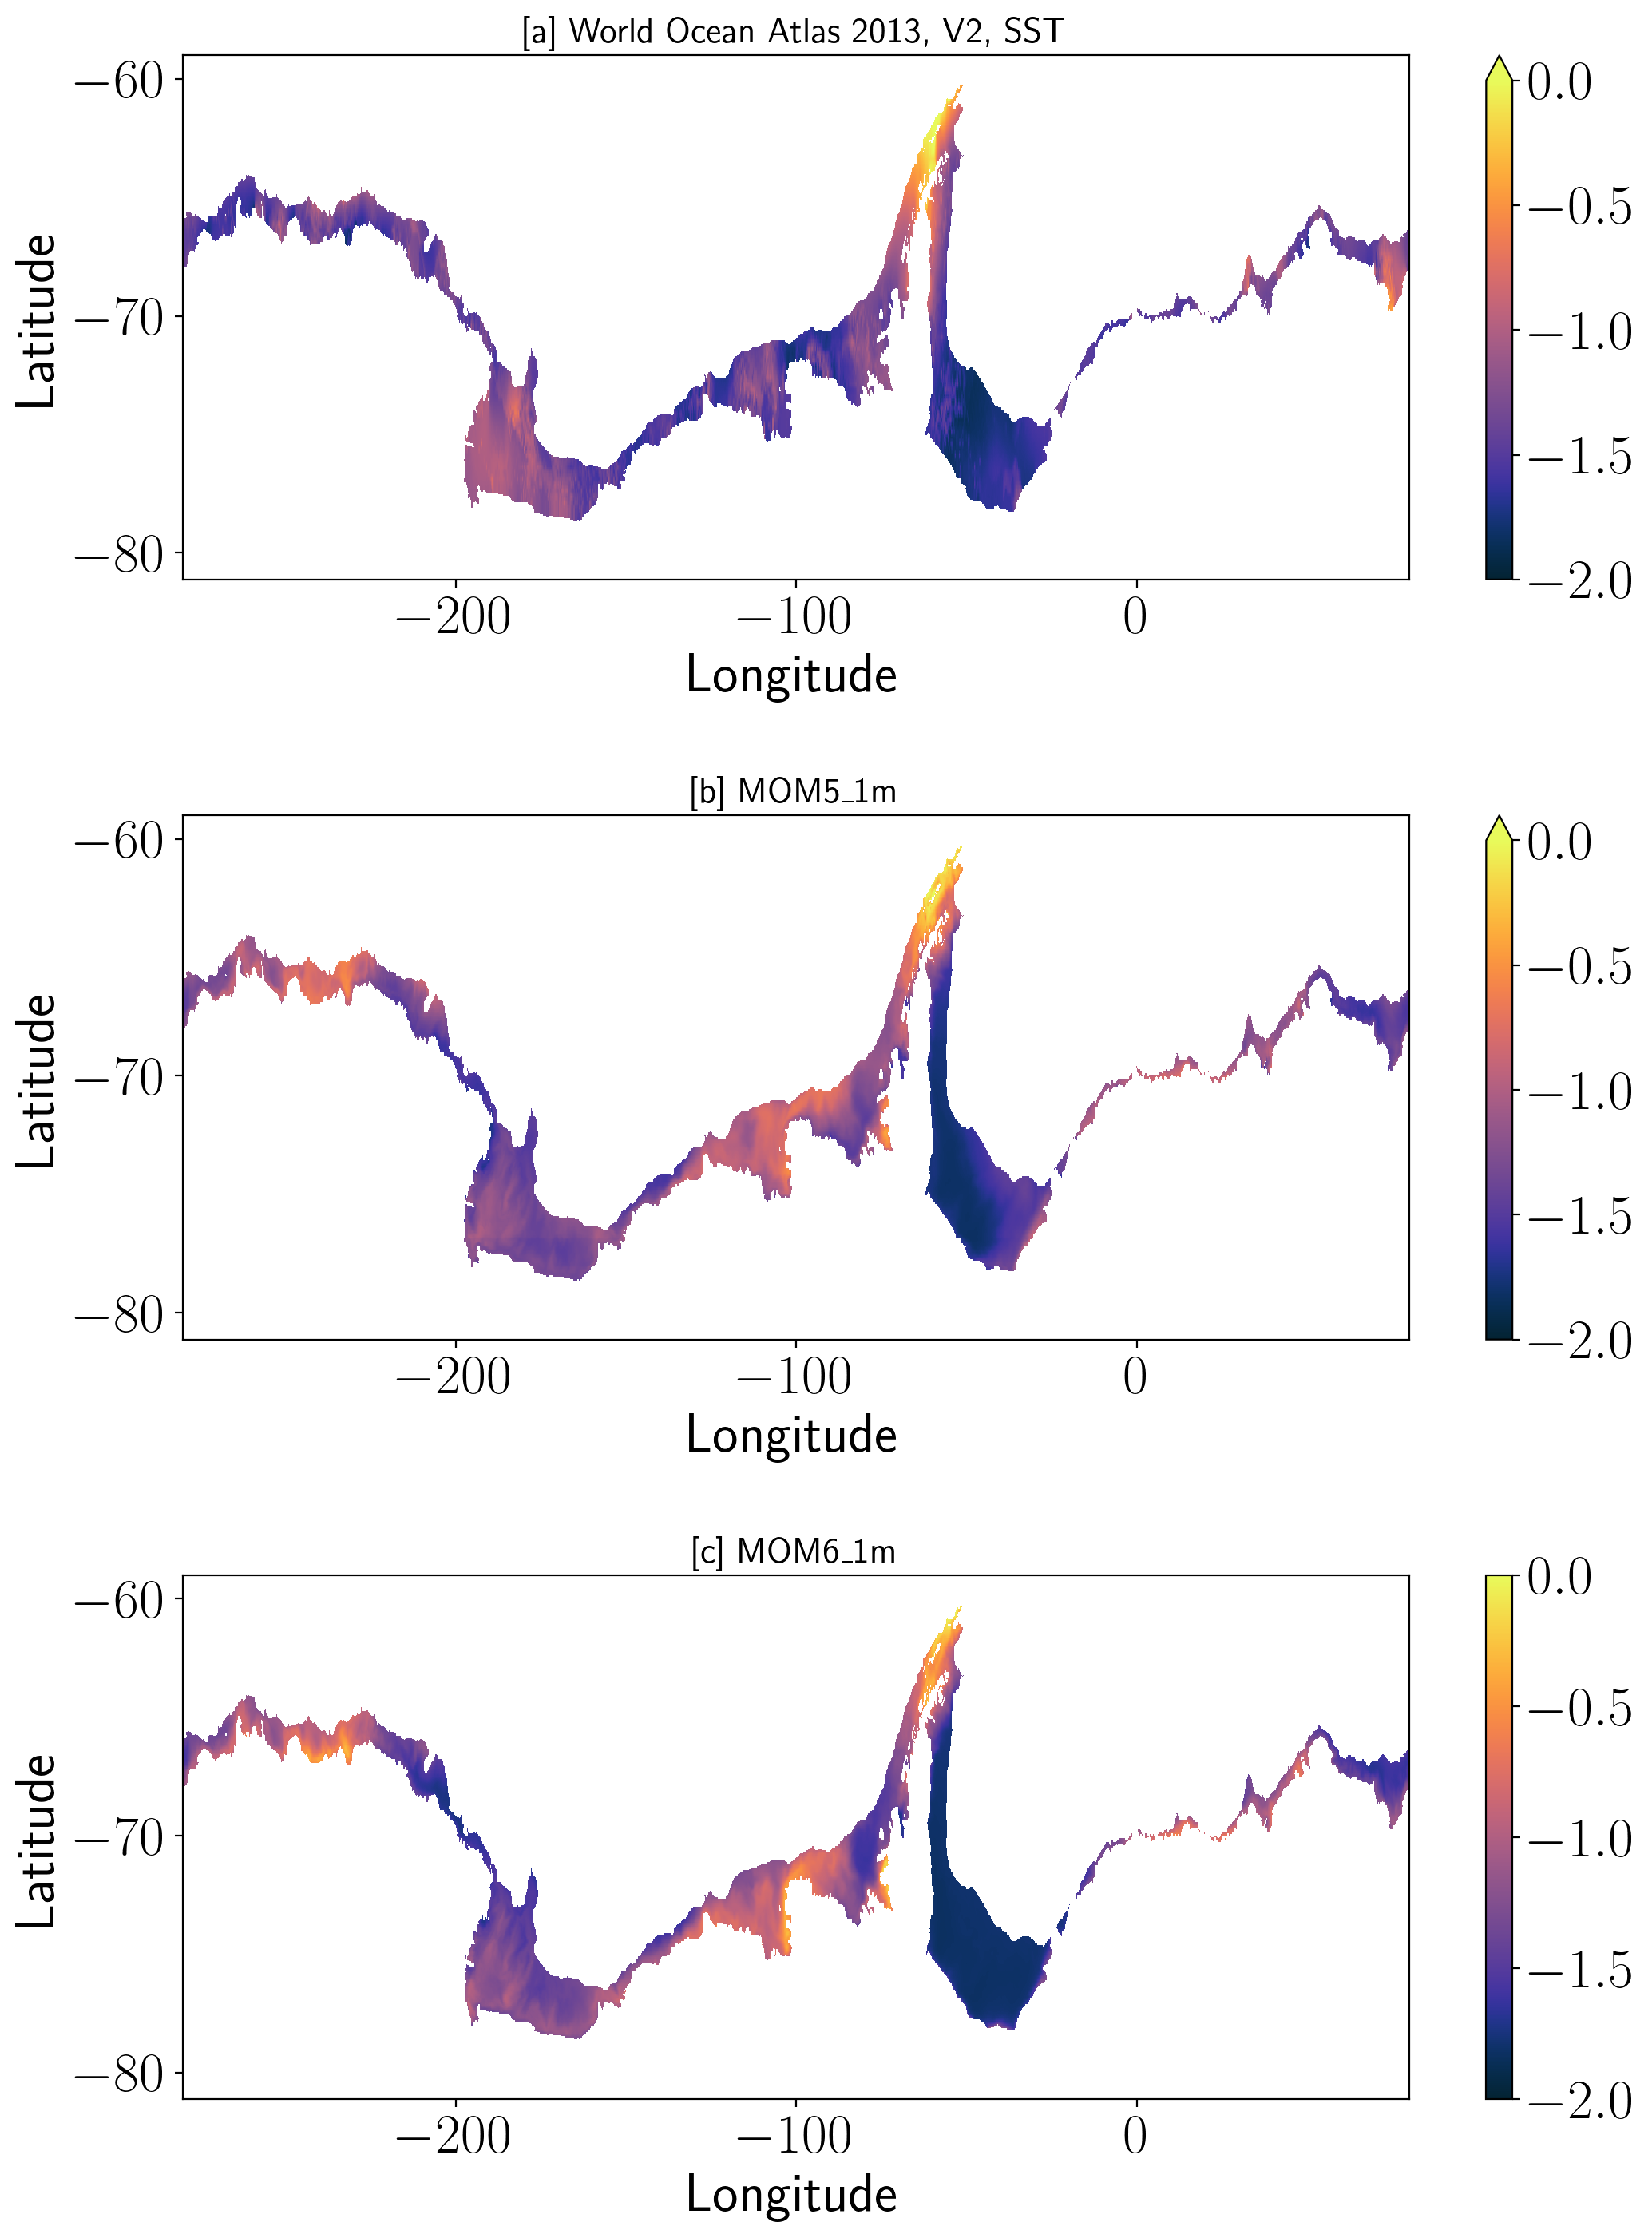

In [28]:
plt.figure (figsize = (12,16))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.35,hspace=0.45)

plt.subplot(3,1,1)
(SST_WOA_shelf * mask).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[a] World Ocean Atlas 2013, V2, SST', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,2)
(SST_MOM5_shelf).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[b] MOM5_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
(SST_MOM6_shelf).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[c] MOM6_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

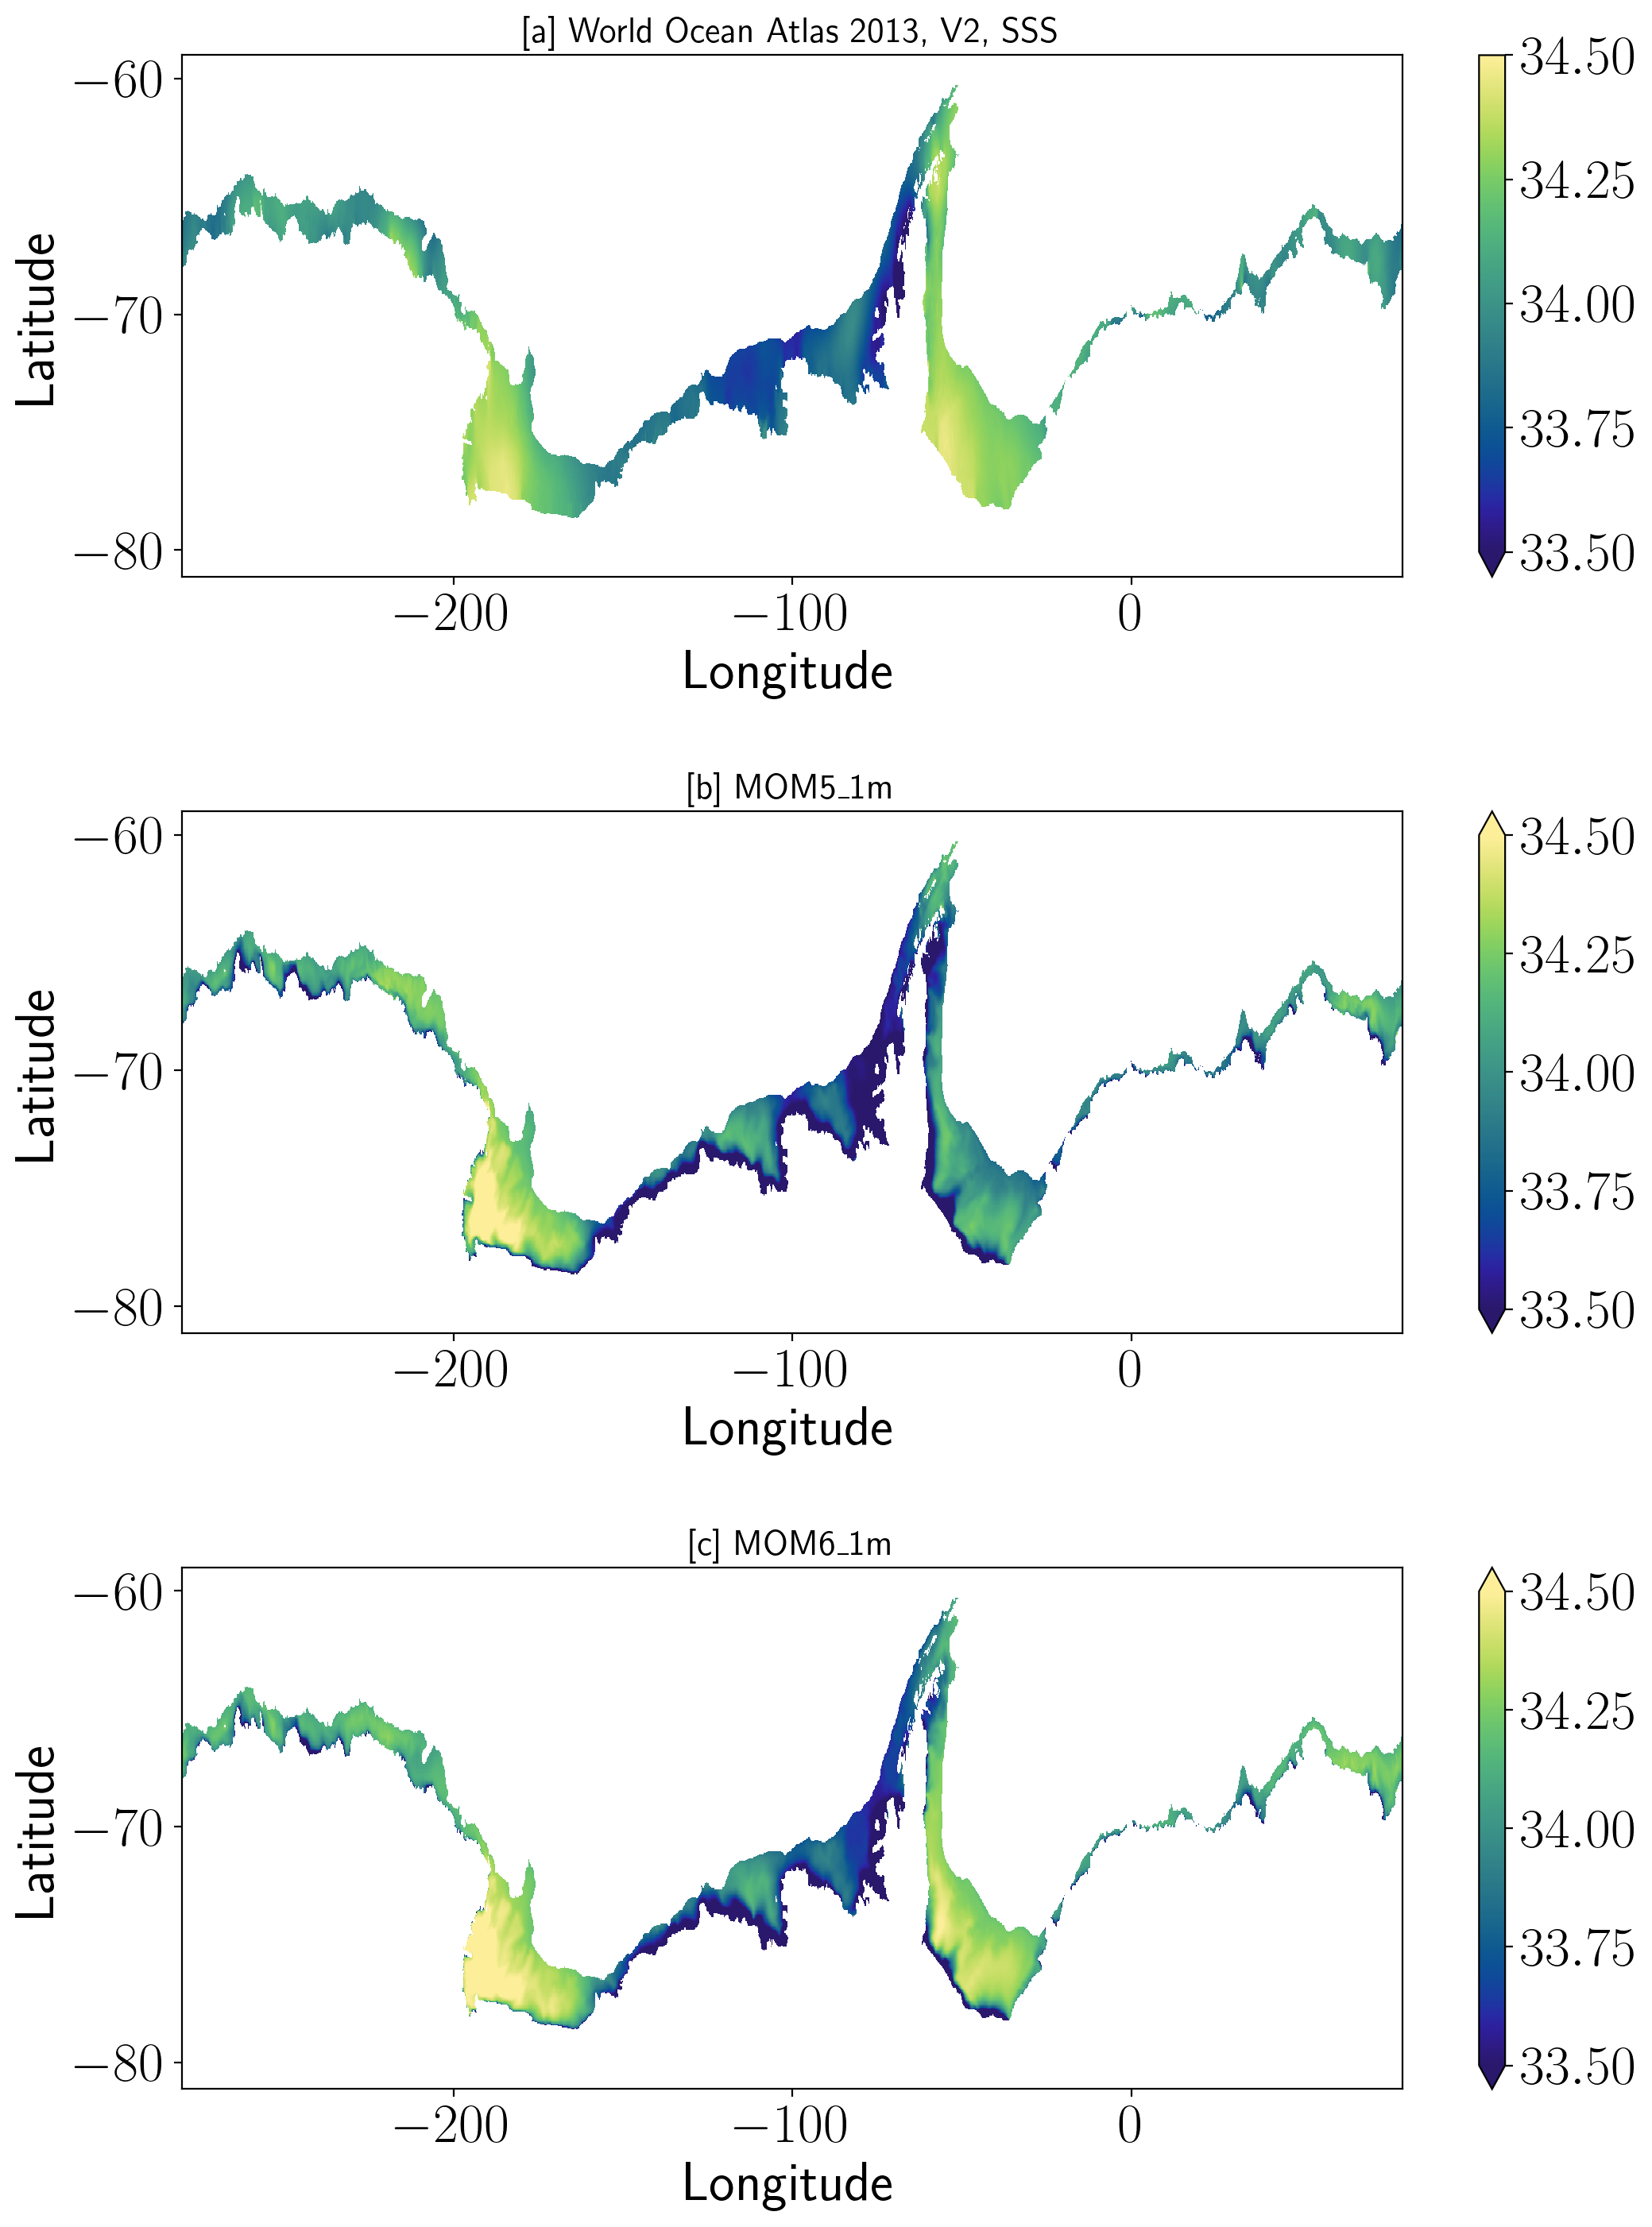

In [29]:
plt.figure (figsize = (12,16))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.35,hspace=0.45)

plt.subplot(3,1,1)
(SSS_WOA_shelf * mask).plot(vmin=33.5,vmax=34.5,cmap=cmo.haline)
plt.title('[a] World Ocean Atlas 2013, V2, SSS', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,2)
(SSS_PSU_MOM5_shelf).plot(vmin=33.5,vmax=34.5,cmap=cmo.haline)
plt.title('[b] MOM5_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
(SSS_PSU_MOM6_shelf).plot(vmin=33.5,vmax=34.5,cmap=cmo.haline)
plt.title('[c] MOM6_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

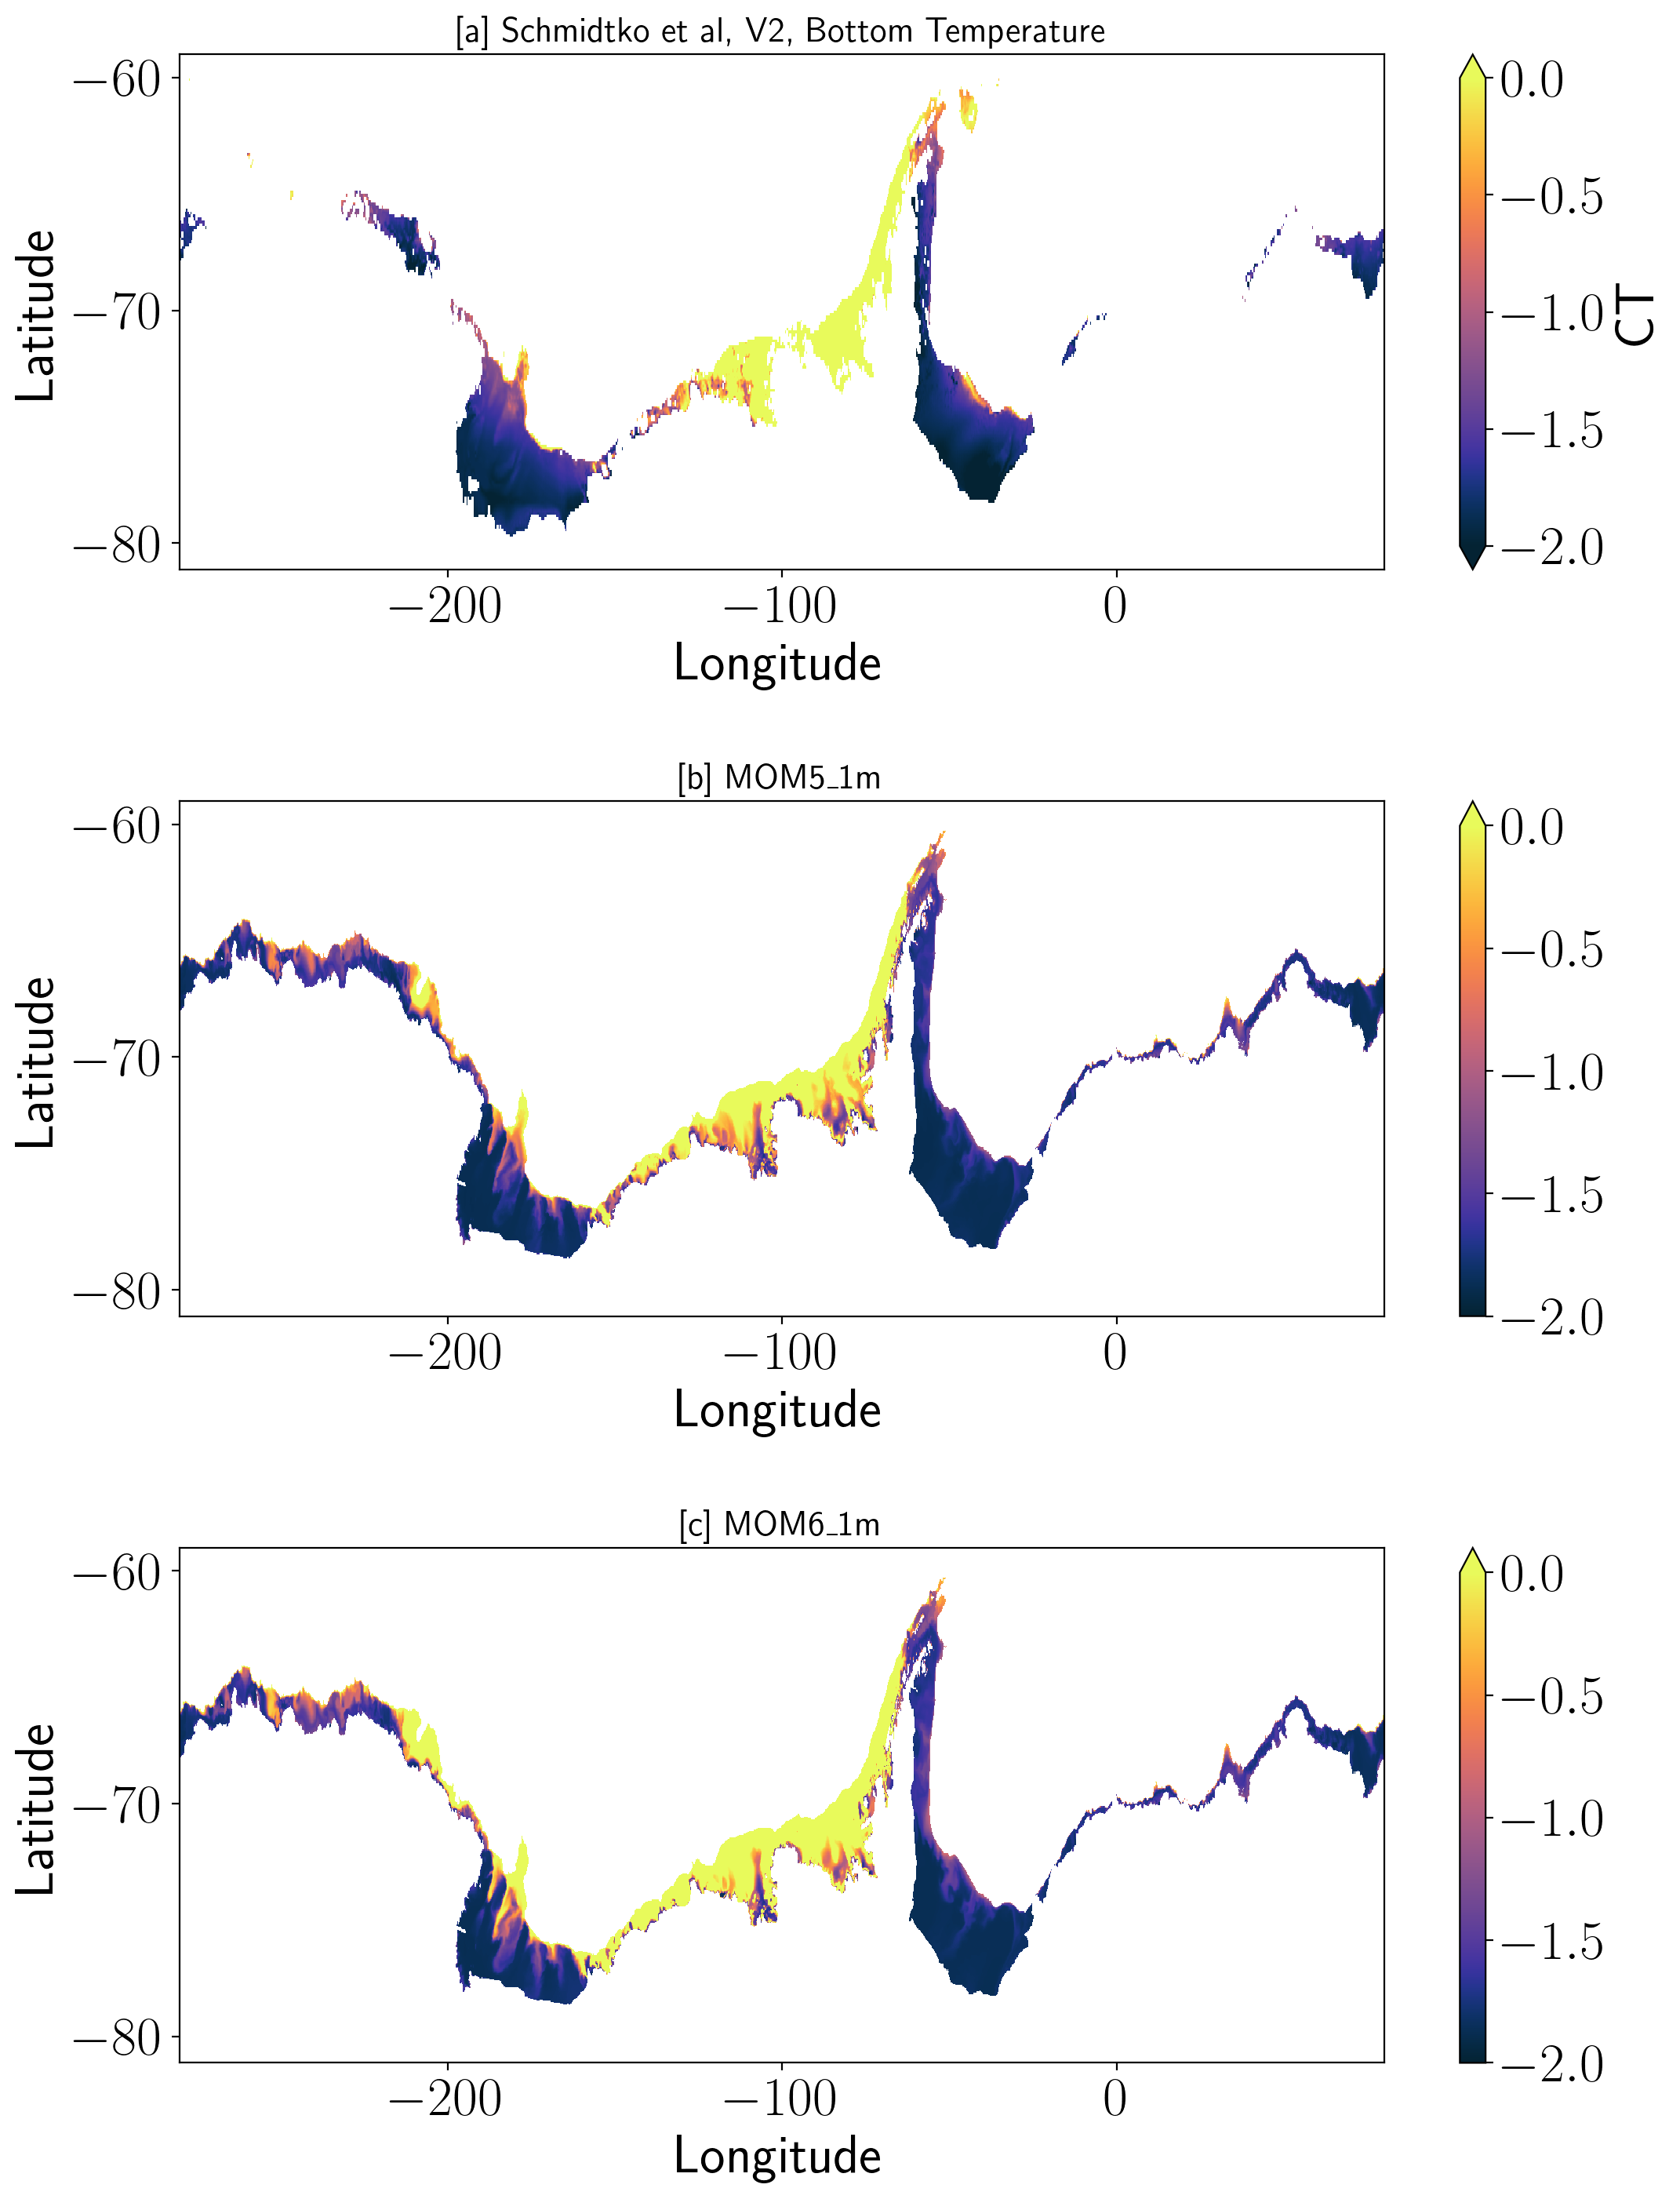

In [30]:
plt.figure (figsize = (12,16))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.35,hspace=0.45)

plt.subplot(3,1,1)
(Tob_Schmidtko).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[a] Schmidtko et al, V2, Bottom Temperature', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,2)
(Tob_MOM5_shelf * mask).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[b] MOM5_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
(Tob_MOM6_shelf * mask).plot(vmin=-2,vmax=0,cmap=cmo.thermal)
plt.title('[c] MOM6_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

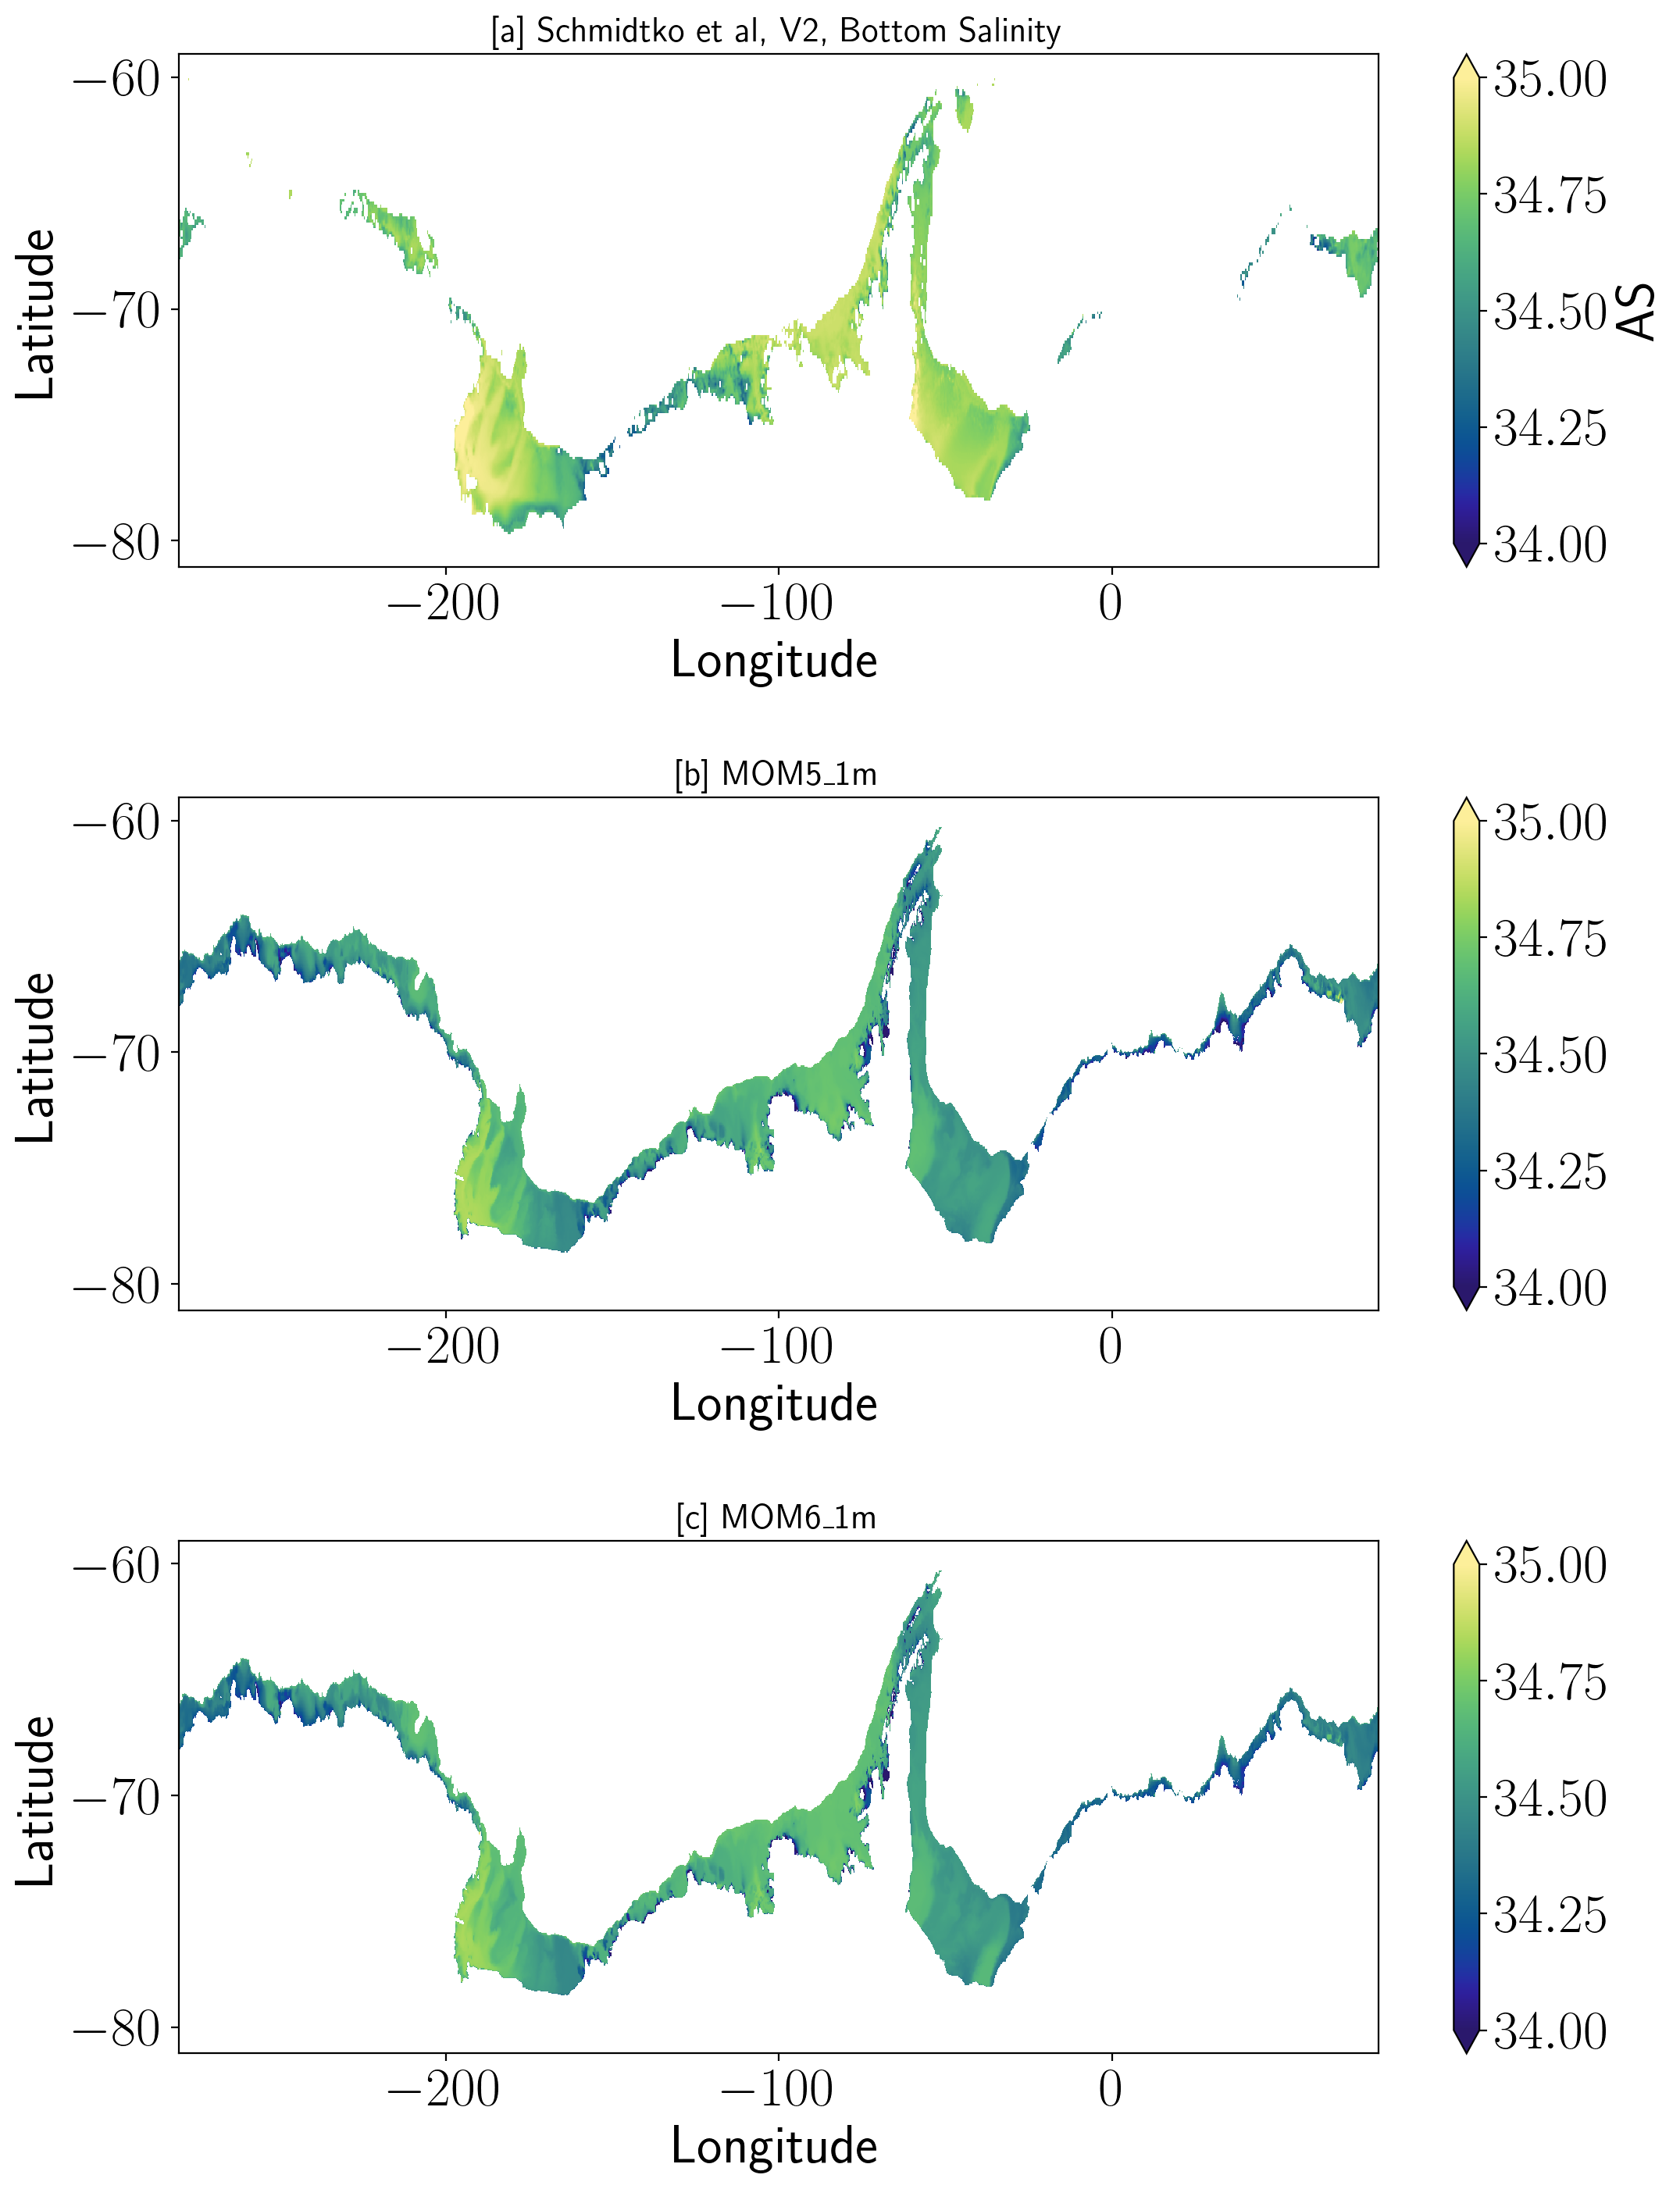

In [31]:
plt.figure (figsize = (12,16))
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.35,hspace=0.45)

plt.subplot(3,1,1)
(Sob_Schmidtko).plot(vmin=34,vmax=35,cmap=cmo.haline)
plt.title('[a] Schmidtko et al, V2, Bottom Salinity', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,2)
(Sob_MOM5_shelf * mask).plot(vmin=34,vmax=35,cmap=cmo.haline)
plt.title('[b] MOM5_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(3,1,3)
(Sob_MOM6_shelf * mask).plot(vmin=34,vmax=35,cmap=cmo.haline)
plt.title('[c] MOM6_1m', fontsize =16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## IV: Pretty plots for supplemetary Material

In [32]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=lat_slice)
ht_50S = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', session, n=1).sel(yt_ocean=slice(-90,-50)).load()
deptho = cc.querying.getvar('panant-01-zstar-ACCESSyr2', 'deptho', session, n=1).sel(yh=slice(-90,-50)).load()
land_mask = (ht*0).fillna(1)
#shelf mask
shelf_mask = shelf_mask_MOM5(SST_MOM5.fillna(0)*0 +1)
shelf_mask_off = shelf_mask.where(shelf_mask<1)+1

In [33]:
def stereoplot(SST_WOA_shelf,n, title,cmap,norms,varname):
    
    proj = ccrs.PlateCarree()
    ax325 = plt.subplot(2,3,n, projection=ccrs.SouthPolarStereo())
    ax325.set_extent([-180, 180, -90, -60], proj)
    ax325.set_boundary(circle, transform=ax325.transAxes)
    latlag = 0
    gl = ax325.gridlines(draw_labels=False, color='darkgray')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
    label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
                 '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
    rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
    lat_lon_label = [-59.5+latlag, -58.7+latlag, -59.5+latlag, -58.5+latlag, -58.5+latlag, -59.2+latlag, -59.5+latlag, -59.2+latlag,
                     -59.5+latlag, -58.7+latlag, -58.7+latlag, -59.5+latlag] 
    for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                                  30, -150, 150, -30]):
        ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
                horizontalalignment='center', verticalalignment='center',
                color='gray', fontsize=10, transform=proj)
    for j in range(70, 90, 10):
        label = str(j) + '°S'
        ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
                verticalalignment='center', color='gray', fontsize=10,
                transform=proj)
    
    
    ax325.contourf(land_mask.xt_ocean.values,
                np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
                land_mask, colors='dimgray', levels=[0.5, 2],
                transform=proj, rasterized=True, zorder=6)
    
    
    
    plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean-0.01, shelf_mask.fillna(0).values,
                levels=[0, 1], colors = 'lightgray', linewidth=.7,
                transform=proj,)
    
    #SST_WOA_shelf * mask
    p325 = ax325.pcolormesh(SST_WOA_shelf.xt_ocean, SST_WOA_shelf.yt_ocean,
                       SST_WOA_shelf * mask,\
                       cmap=cmap, vmin=norms[0],vmax=norms[1],transform=proj,
                        zorder=0)
    
    
    
    
    
    
    pos = ax325.get_position()
    cax = plt.axes([pos.xmin+0.03, pos.ymin-0.04,
                    .6*(pos.xmax-pos.xmin), 0.02])
    
    title_indexes = ['a','b','c','d','e','f','g','h','i','j']
    cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax, extend='max')
    cb325.ax.tick_params(labelsize=12)
    cb325.ax.set_xlabel(varname,fontsize=13)
    if n<=3:
        ax325.set_title(title,fontsize = 16)


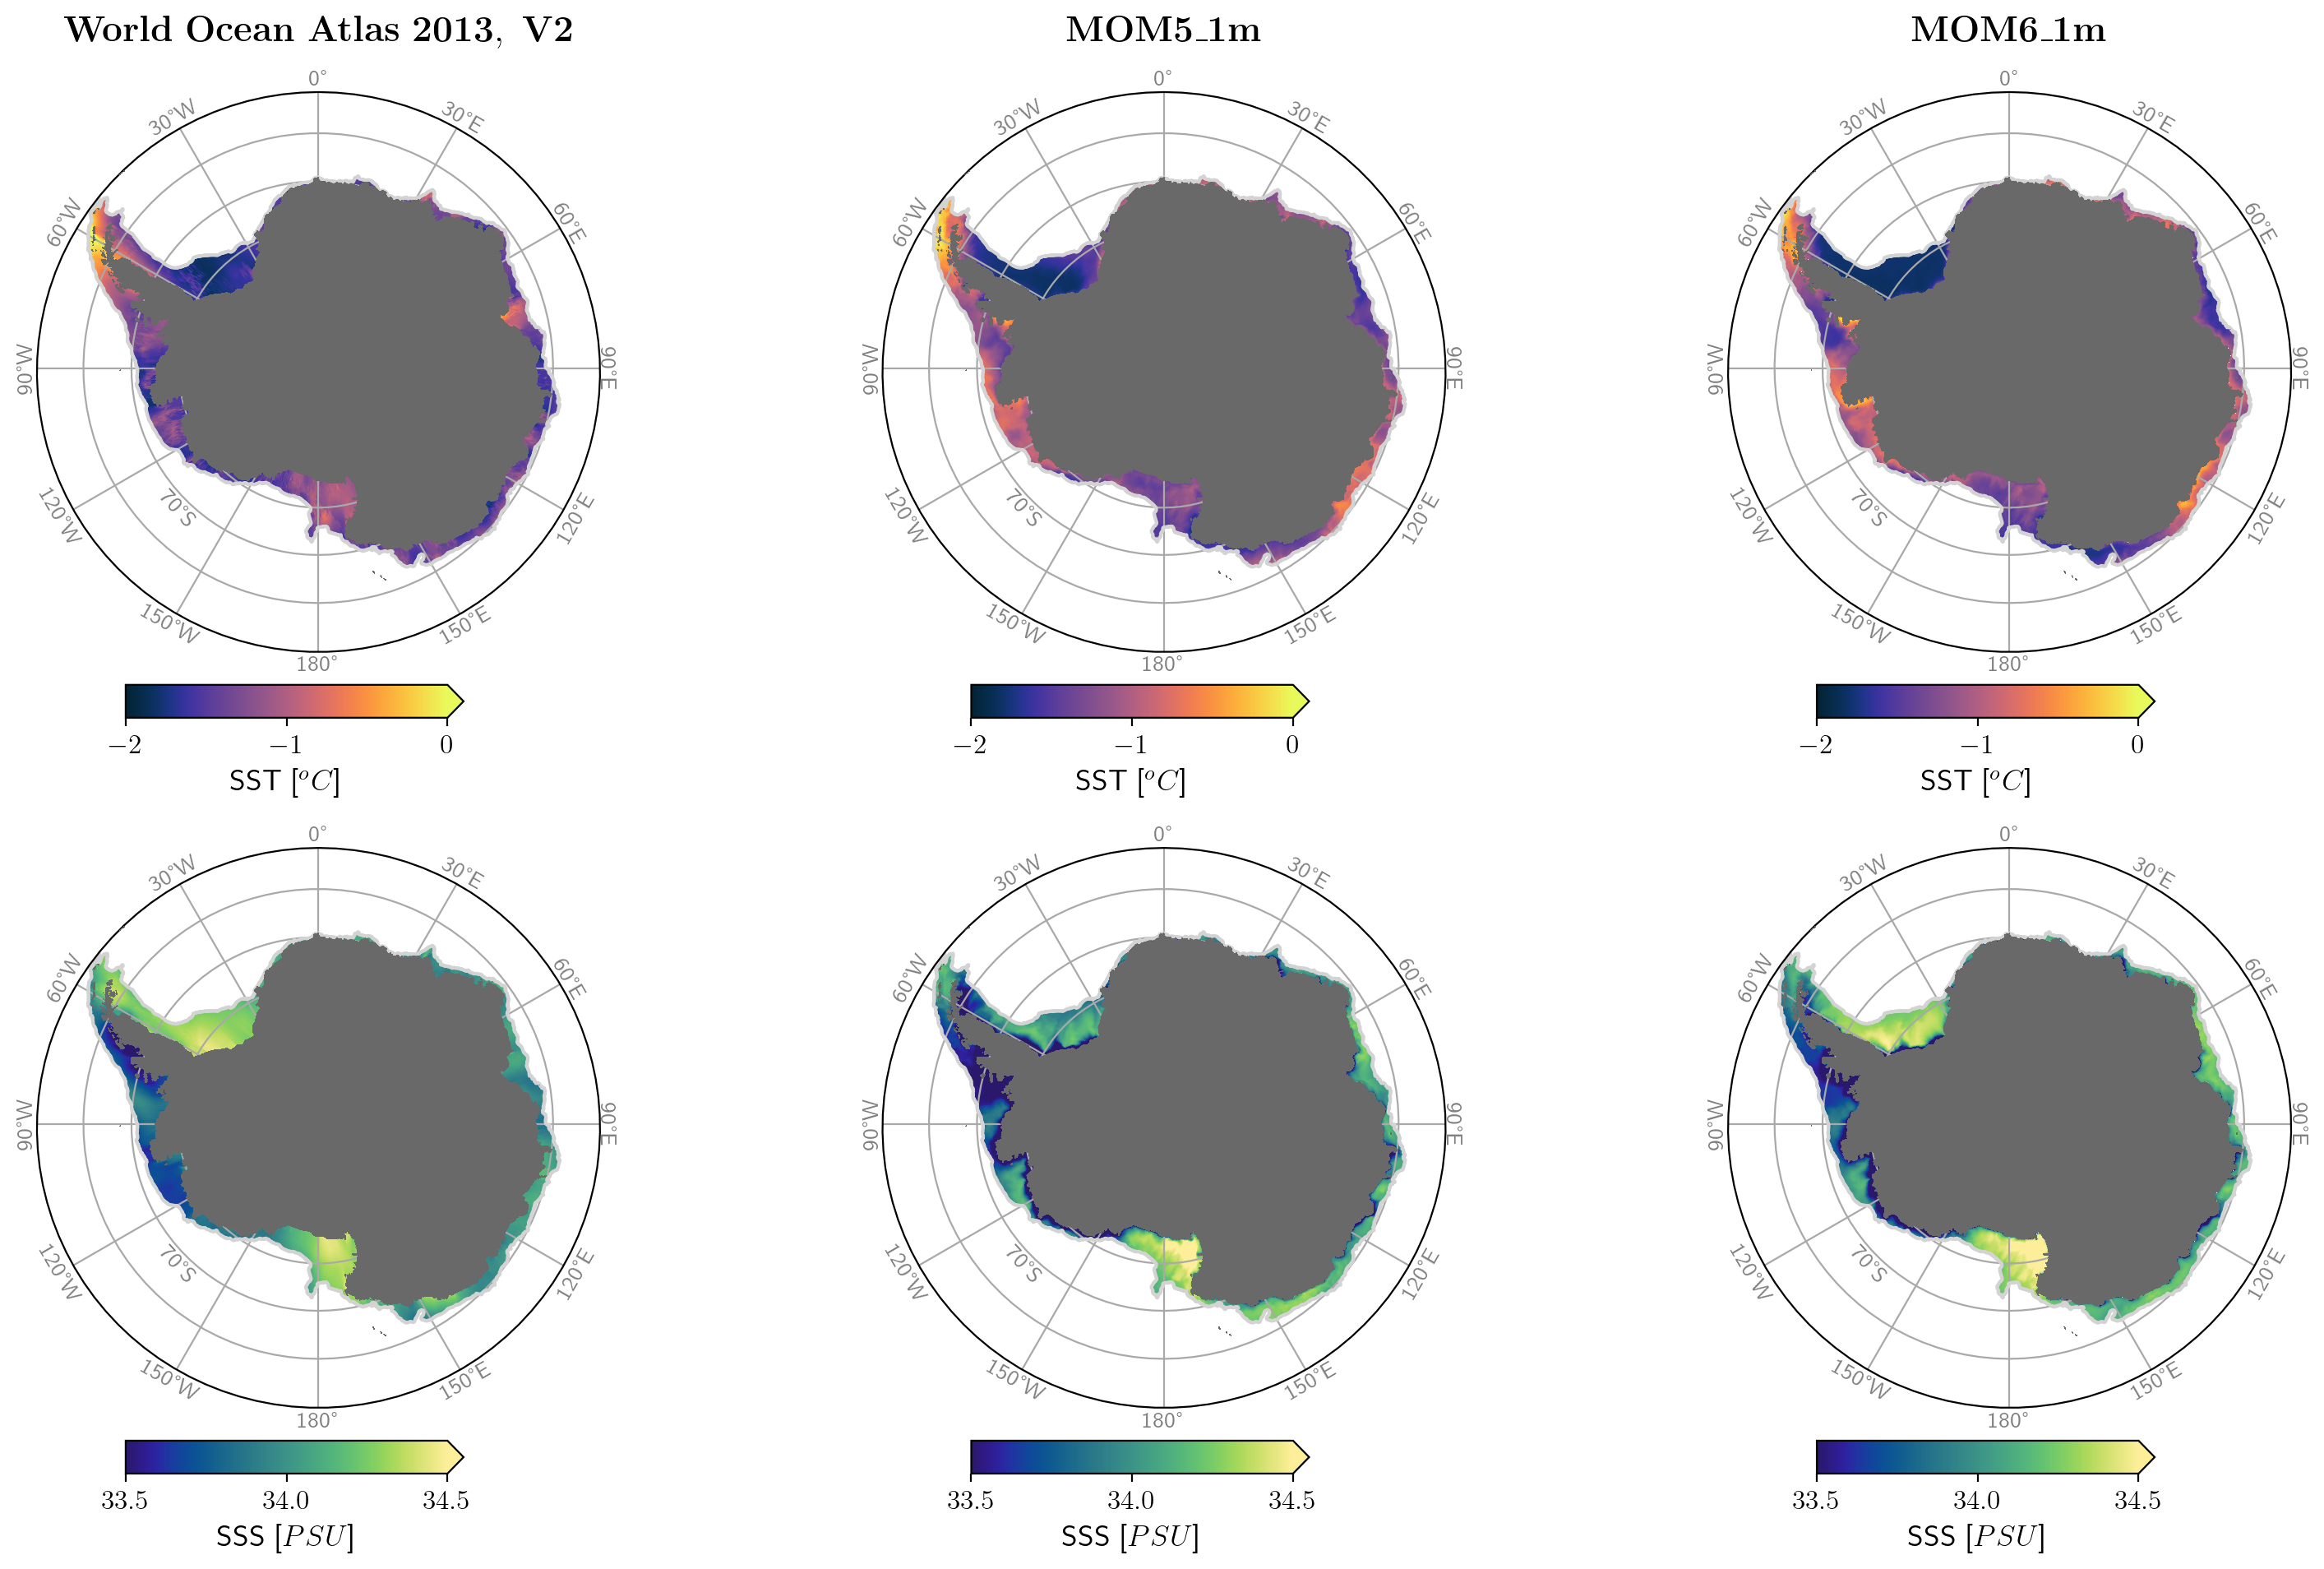

In [44]:
#figure 1, SST and SSS
figure = plt.figure(num = 1, figsize = (18, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.35)

title0 = r'$\bf{World\ Ocean\ Atlas\ 2013,\ V2}$'+ ' \n'
title1 = r'$\bf{MOM5\_1m}$'+ ' \n'
title2 = r'$\bf{MOM6\_1m}$'+ ' \n'
#SST

stereoplot(SST_WOA_shelf,1,title0,cmo.thermal,[-2,0],r'SST [$^oC$]')
stereoplot(SST_MOM5_shelf,2,title1,cmo.thermal,[-2,0],r'SST [$^oC$]')
stereoplot(SST_MOM6_shelf,3,title2,cmo.thermal,[-2,0],r'SST [$^oC$]')

#SSS
stereoplot(SSS_WOA_shelf,4,title0,cmo.haline,[33.5,34.5],r'SSS [$PSU$]')
stereoplot(SSS_PSU_MOM5_shelf,5,title0,cmo.haline,[33.5,34.5],r'SSS [$PSU$]')
stereoplot(SSS_PSU_MOM6_shelf,6,title0,cmo.haline,[33.5,34.5],r'SSS [$PSU$]')


plt.savefig(figpath+'Rv0_Figure_S7.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'Rv0_Figure_S7.pdf',dpi=300,bbox_inches='tight')

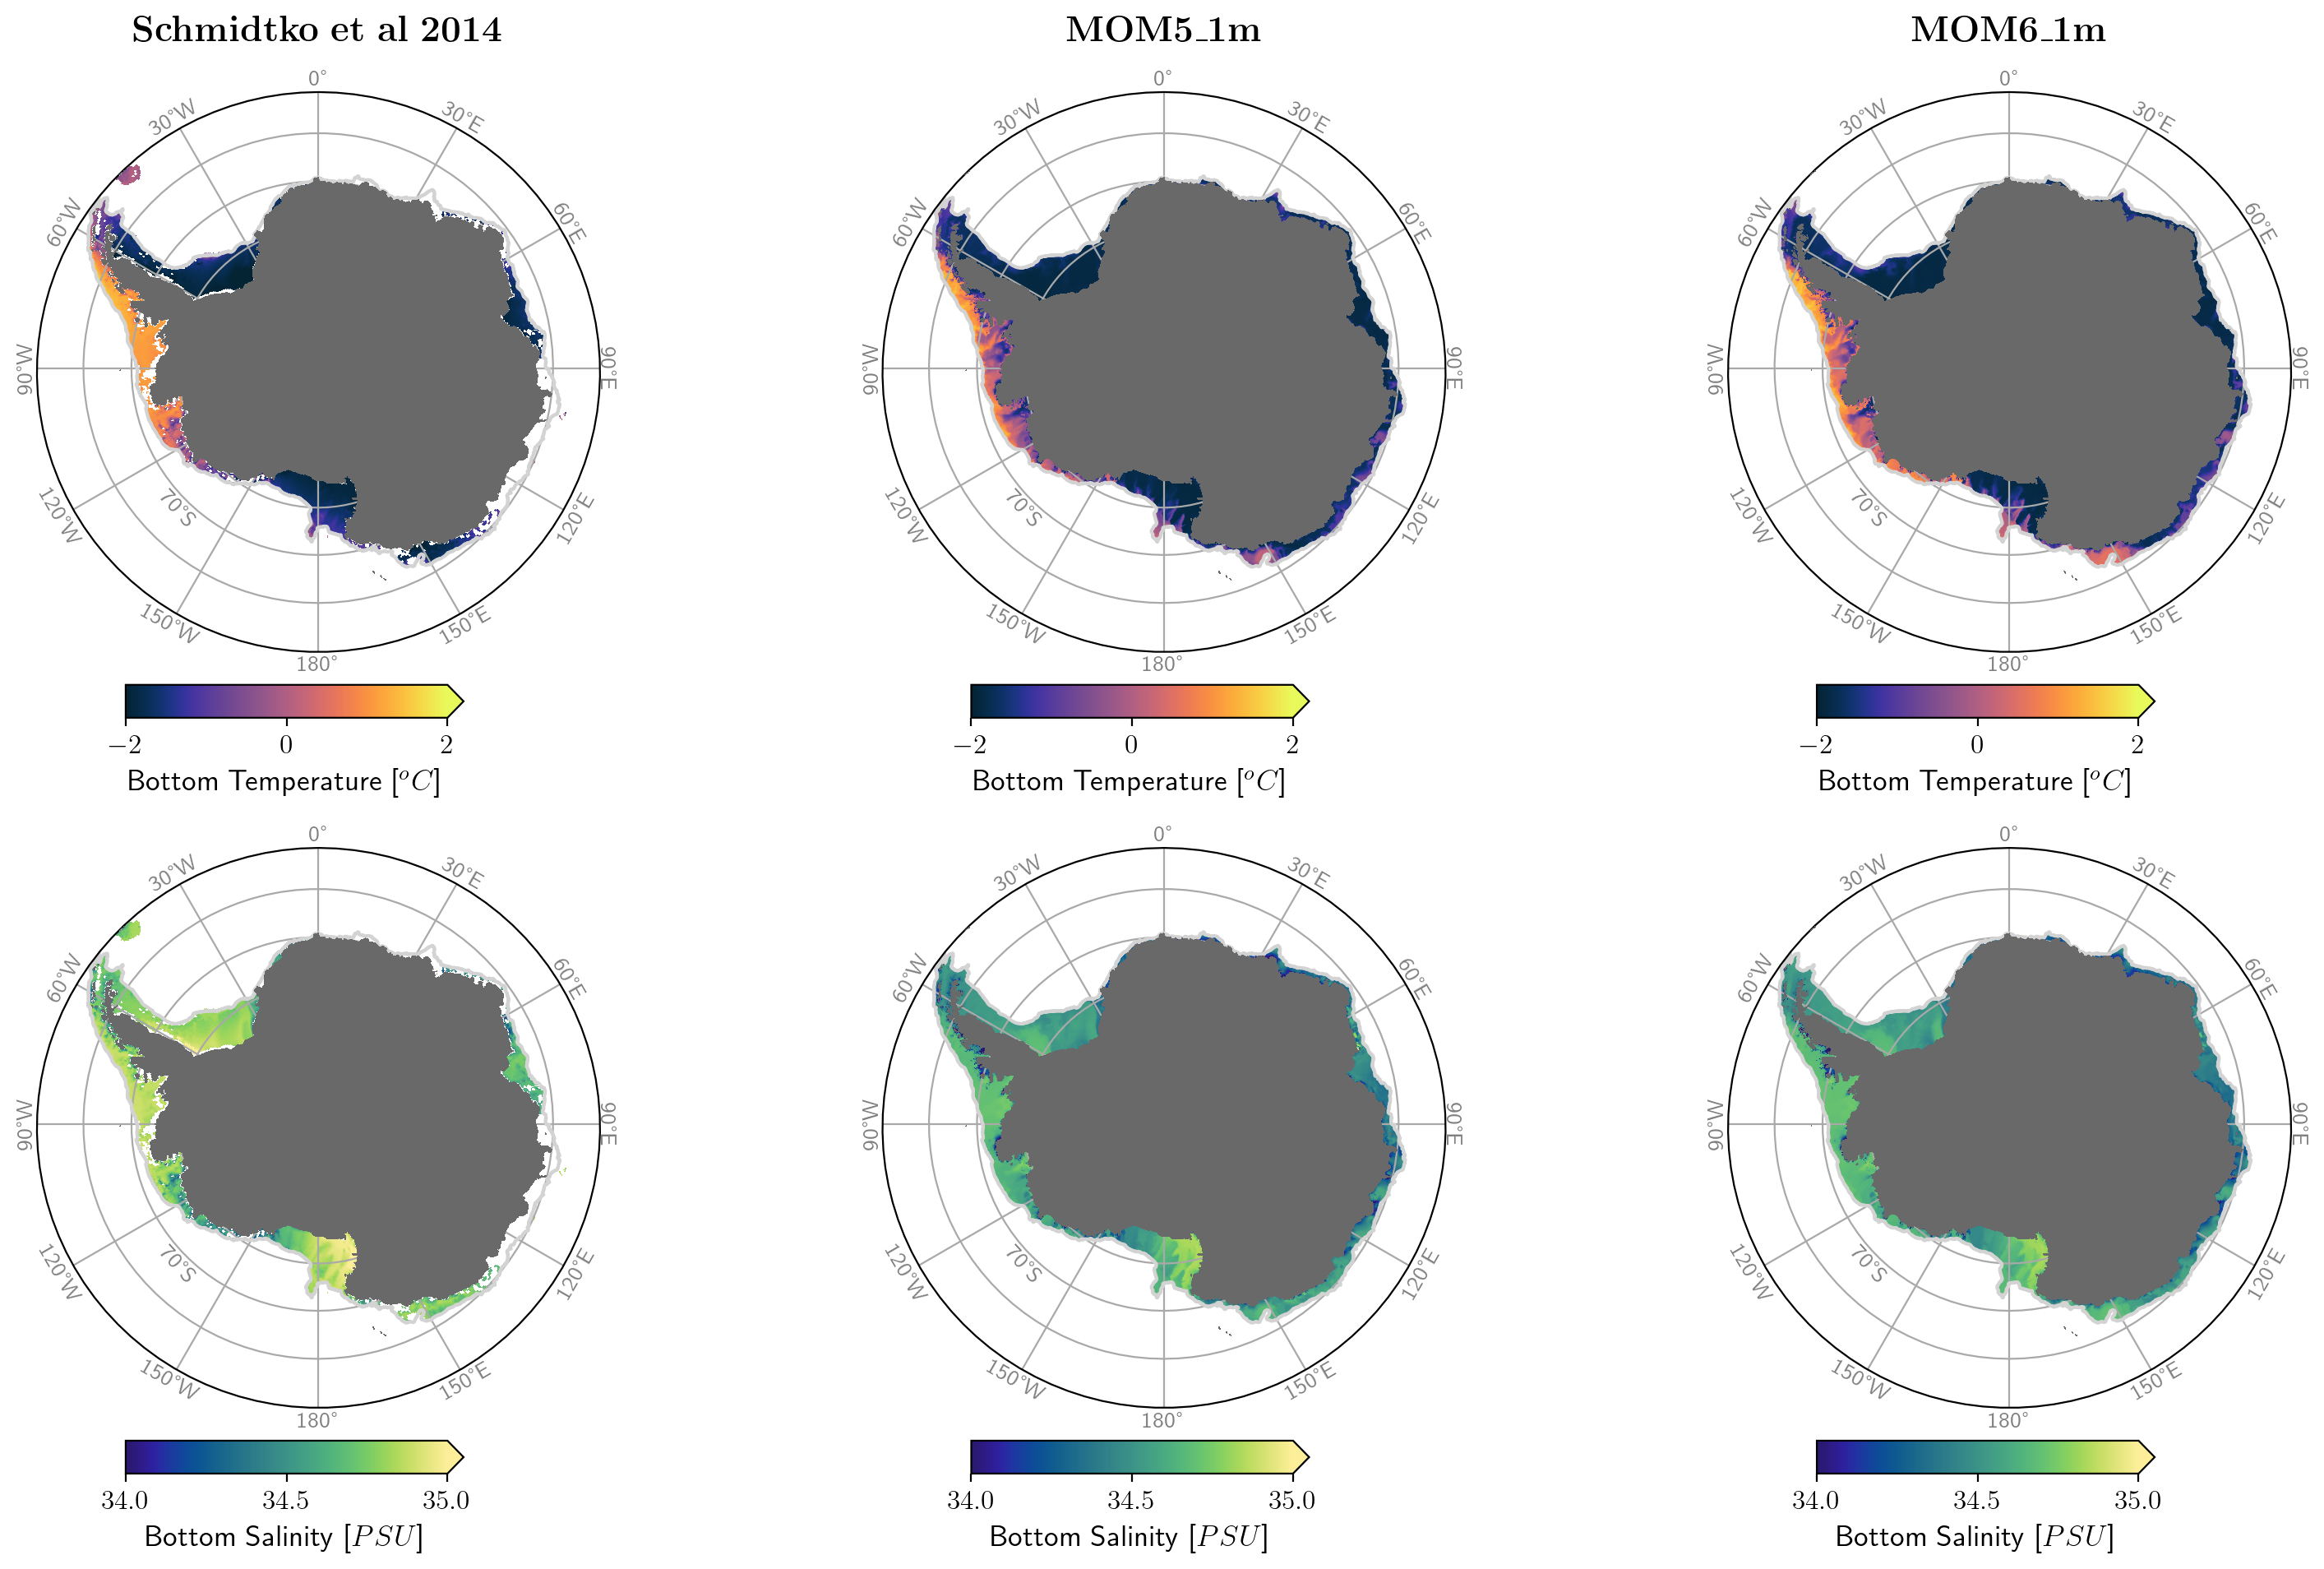

In [47]:
#figure 1, SST and SSS
figure = plt.figure(num = 1, figsize = (18, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.25,
                    hspace=0.35)

title0 = r'$\bf{Schmidtko\ et\ al\ 2014}$'+ ' \n'
title1 = r'$\bf{MOM5\_1m}$'+ ' \n'
title2 = r'$\bf{MOM6\_1m}$'+ ' \n'
#SST
stereoplot(Tob_Schmidtko,1,title0,cmo.thermal,[-2,2],r'Bottom Temperature [$^oC$]')
stereoplot(Tob_MOM5_shelf * mask,2,title1,cmo.thermal,[-2,2],r'Bottom Temperature [$^oC$]')
stereoplot(Tob_MOM6_shelf * mask,3,title2,cmo.thermal,[-2,2],r'Bottom Temperature [$^oC$]')

#SSS
stereoplot(Sob_Schmidtko,4,title0,cmo.haline,[34,35],r'Bottom Salinity [$PSU$]')
stereoplot(Sob_MOM5_shelf * mask,5,title0,cmo.haline,[34,35],'Bottom Salinity [$PSU$]')
stereoplot(Sob_MOM6_shelf * mask,6,title0,cmo.haline,[34,35],'Bottom Salinity [$PSU$]')


plt.savefig(figpath+'Rv0_Figure_S8.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'Rv0_Figure_S8.pdf',dpi=300,bbox_inches='tight')